<a name="outline"></a>

## Outline

- [Task 1](#task-1): Neural networks
  - [1.1](#q11) Multi-layer perceptron
  - [1.2](#q12) Convolutional neural network (CNN)
- [Task 2](#task-2): Unsupervised learning
  - [2.1](#q21) Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data
  - [2.2](#q22) Clustering of the feature matrix
  - [2.3](#q23) Graph-based analysis 
- [Task 3](#task-3): Mastery component 
  - [3.1](#q31) Non-Negative Matrix Factorization (NMF) for dimensionality reduction 
  - [3.2](#q32) Community detection


In [1]:
# Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import time 
import networkx as nx 
from tabulate import tabulate
import seaborn as sns
from scipy.sparse import linalg

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


<a name="task-1"></a>
# Task 1: Neural networks [^](#outline)



In [14]:
# Load Fashion-MNIST dataset of images for classification

def load_data():
    
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    
    # Scale the colour values between 0 and 1
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    #convert labels to categorical samples
    y_train = tf.keras.utils.to_categorical(y_train, num_classes = 10)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes = 10)
    
    return ((x_train, y_train), (x_test, y_test))

(x_train, y_train), (x_test, y_test) = load_data() # Training and validation data
#shuffle data randomly
np.random.seed(1)
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]

<a name="q11"></a>

## 1.1 Multi-layer perceptron [^](#outline)



1.1.1

We begin by implementing a multi-layer perceptron (MLP) using only NumPy. We construct the architecture below. We create an input layer with 784 units (since we have 784 = 28 by 28 from the pixel shape of each image in the training data) with no activation function and five hidden layers, using the LeakyReLU function with a slope of 0.01 as activation between these layers. We design the network to classify images belonging to 10 classes of items sold in an online fashion store from the Fashion-MNIST dataset. The output values will be probabilities that the input image is from one of the ten classes given by the softmax function as the activation function on the output layer. We fix the optimisation method to be stochastic gradient descent (SGD) and the loss function will be (categorical) cross-entropy.

In [15]:
#Defining the architecture of the network
act = [{'units': 784, 'activation': 'None'}] + 5 * [{'units': 400, 'activation': 'LeakyReLU'}] + [{'units': 10, 'activation': 'softmax'}]
print(act)

[{'units': 784, 'activation': 'None'}, {'units': 400, 'activation': 'LeakyReLU'}, {'units': 400, 'activation': 'LeakyReLU'}, {'units': 400, 'activation': 'LeakyReLU'}, {'units': 400, 'activation': 'LeakyReLU'}, {'units': 400, 'activation': 'LeakyReLU'}, {'units': 10, 'activation': 'softmax'}]


Defining the activation functions needed and the derivative of the LeakyReLu

In [16]:
def LeakyReLU(x, slope=0.01):
    return slope * x if x < 0 else x
LeakyReLU = np.vectorize(LeakyReLU)

In [17]:
def dLeakyReLU(x,slope=0.01):
    if x == 0:
        raise ValueError("Not defined at 0")
    return slope if x < 0 else 1
dLeakyReLU = np.vectorize(dLeakyReLU)

In [18]:
def softmax(x):
    z = x - np.max(x, axis = 0) # More stable formulation of softmax
    return np.exp(z) / np.sum(np.exp(z), axis = 0)

We can visualize the LeakyReLU function. The difference between this and the normal ReLU is that the slope for negative values is not 0. Here we specify it is 0.01.

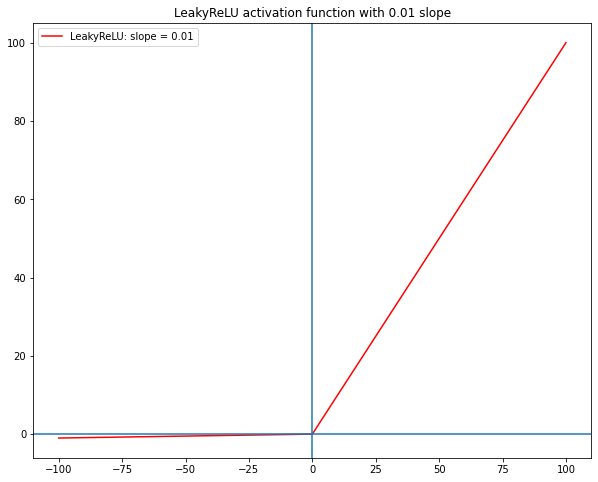

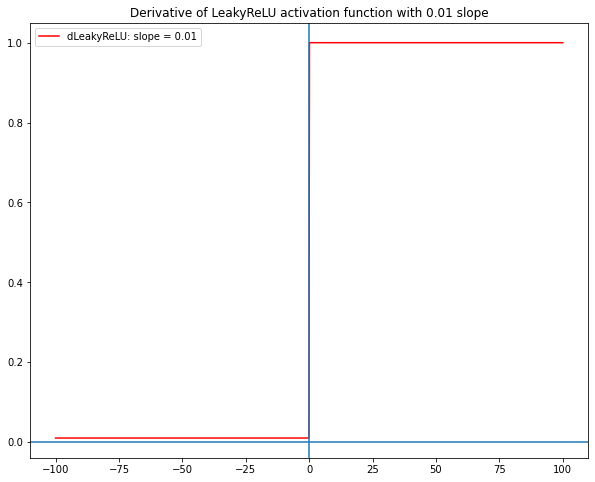

In [19]:
x = np.linspace(-100,100,1000)
y = LeakyReLU(x)
plt.figure(figsize=(10,8))
plt.plot(x,y,color='red',label="LeakyReLU: slope = 0.01")
plt.axhline(0)
plt.axvline(0)
plt.legend()
plt.title("LeakyReLU activation function with 0.01 slope")
plt.show()
x = np.linspace(-100,100,1000)
y = dLeakyReLU(x)
plt.figure(figsize=(10,8))
plt.plot(x,y,color='red',label="dLeakyReLU: slope = 0.01")
plt.axhline(0)
plt.axvline(0)
plt.legend()
plt.title("Derivative of LeakyReLU activation function with 0.01 slope")
plt.show()

Now we implement the initialisation function. This sets up to the initial parameters (weights and biases) in our network. When
we input batches of data through the system, we backpropagate erros and gradients to these parameters will be computed, moving closer
to the optimized configuration (at the learning rate speed). The optimized configuration is the weight matrices and bias vectors that minimize the loss function.

In [20]:
#initialize weight matrices and bias vectors between layers to update every epoch
def initialise():
    params = {}
    for i in range(1, len(act)):
        #weights are initalised randomly from normal distribution 
        #biases set to 0 vectors
        var = 2 / (act[i]['units'] + act[i-1]['units'])
        params[f'W{i-1}'] = np.random.normal(loc = 0.0, scale = np.sqrt(var), size = (act[i]['units'], act[i-1]['units']))
        params[f'b{i-1}'] = np.zeros((act[i]['units'], 1))
    return params

Next, we implement the forward pass function which propagates batches of our data forwards through our layers. The output is a prediction on the label of the image. As stated prior, for this network we have 10 classes and so will output a 10 dimensional probability vector with each entry showing the probability of the image being assigned to the corresponding class. We classify the image in the class that has greatest corresponding probability from the model. For when we implement backpropagation we will also return the pre and post activations at each layer in the forward pass function.

In [21]:
def f_pass(x, params):
    # we store the pre-activations and post-activations for when we will undergo error backpropagation
    storage = {}
    #the input data is stored as both the pre- and post-activation of the input layer 
    storage['a0'], storage['h0'] = x, x
    h = x #by defininition of h0
    for i in range(1, len(act)): 
        a = params[f'W{i-1}'] @ h + params[f'b{i-1}'] # find pre-activation of ith layer
        h = LeakyReLU(a) if act[i]['activation'] == 'LeakyReLU' else softmax(a) # find post-activation of ith layer
        #storing pre-activations and post-activations in ith layer
        storage[f'a{i}'], storage[f'h{i}'] = a, h
    pred = storage[f'h{len(act) - 1}'] #last post-activation is the predicting probability distribution
    return pred, storage

As the output layer activation is softmax, we decide to use cross-entropy for the loss
function. Specifically, this is categorical cross-entropy, used for multi-class classification of one-hot encoded target variables. One-hot encoding is when the truth values or argmaxed predicted values take the form of a vector with 1 in the position of the class of the variable and 0 elsewhere.
$$ \text{Categorical cross entropy} = - \frac{1}{N_j}\sum_j y_j \log \hat{y_j} $$
where $y$ is the ground truth and $\hat{y}$ is our predicted classification.
We note that often the Categorical Cross Entropy is defined without the division of the number of predictions but we have this term so that when visualising the loss progression over epochs we do not have vastly different scales for validation and training data. Dividing by a constant will not affect the optimisation of this loss in any way.

In [22]:
# Cross-entropy between real and predicted output averaged across data
def cross_entropy(y, y_hat):
    y, y_hat = np.asarray(y), np.asarray(y_hat)
    y_hat = y_hat + 1e-16 # avoid log(0) error
    return -np.mean(np.multiply(y, np.log(y_hat))[y != 0]) # Computes cross-entropy
    


Accuracy is given by the number of correct classifications over the total number of classifications.

In [23]:
# Accuracy of predictions compared to correct classification
def accuracy(y, y_hat):
    pred = np.zeros(y_hat.shape)
    pred[np.where(y_hat == y_hat.max(axis = 0))] = 1 #maps probabilities to one-hot encoded vectors
    return np.mean((pred == y).all(axis = 0)) #take proportion of correct predictions

Our backward pass function will first find the final error in the last layer, for softmax activation and cross-entropy loss we have $$\delta^{L+1} = \hat{y}-y$$in the prediction and will propagate it back through our network to obtain a similar error at each layer using the relation we derived in the notes $$\delta_k^p = \sigma^{'}(a_p^k)\sum_{j=1}^{n_{k+1}}w_{jp}^k\delta_j^{k+1}$$ $$\delta^k=\sigma^{'}(\bold{a}^k)(\bold{W}^k)^T\delta^{k+1}$$ We use the errors to compute the gradients which are required in SGD to update the weights matrices and bias vectors in our model after each epoch. In computing the gradients we will use the gradient of the leaky ReLU function that we defined earlier. These parameters are altered by SGD in order to move closer to the optimising parameters. Here optimising is minimising the loss function described above.

In [24]:
def b_pass(y, pred, storage, params, batch_size, learning_rate):
    grads = {}
    #find gradient of loss in softmax output layer
    grads[f'del{len(act)-1}'] = pred - y #output layer error
    for i in range(len(act)-1,0,-1): #loop back over layers
        W = params[f'W{i-1}'] # weight matrix at current layer
        b = params[f'b{i-1}'] # bias vector at current layer
        a = storage[f'a{i-1}'] # pre-activations
        h = storage[f'h{i-1}'] # post-activations
        # backpropagates error through layers
        if act[i-1]['activation'] == 'LeakyReLU':
            grads[f'del{i-1}'] = (W.T @ grads[f'del{i}']) * dLeakyReLU(a) # ith layer error
        # compute gradients of weights and biases at each layer
        grads[f'dW{i-1}'] = grads[f'del{i}'] @ h.T # weight matrix gradients
        grads[f'db{i-1}'] = grads[f'del{i}'].mean(axis = 1) # bias vector gradients
        grads[f'db{i-1}'] = grads[f'db{i-1}'].reshape((grads[f'db{i-1}'].size, 1))
        # sgd
        params[f'W{i-1}'] -= learning_rate * grads[f'dW{i-1}'] / batch_size # updates weight matrix
        params[f'b{i-1}'] -= learning_rate * grads[f'db{i-1}'] # updates bias vector
    return params 

We finally have all the necessary function needed to compile the MLP model. First, we batch our training data by dividing it into equal sized samples. Then we initialise the weight matrices and bias vectors of the network. For each batch of data, we input it into our network and pass it forward through the layers applying the current network parameters. We then find the prediction error, outlined above, and backpropagate finding erros with respect to each pre-activation in each layer. Using these, we find the gradients of the paramaters and then apply the SGD algorithm to move in the direction away from increasing gradient to minimise the loss on the current batch. After all our batches have been fed through, we input the entire training set, compromising of all the batches, into the network with the updated parameters and we find the loss and accuracy of our prediction of the whole training set and the predicition of the whole validation set. The key idea behind the validation set is that we never batch the data and never use it to update network parameters but withhold it to test the model on unseen data. This finishes one epoch. We repeat for a large enough number of epochs, retaining the network parameters between epoch ends and starts to minimize the loss and increase accuracy to a sufficient standard. Below we combine all these ideas to compile the MLP using some of the previously implemented functions.

In [25]:
def mlp_numpy(x_train, y_train, x_test, y_test, batch_size, learning_rate, epochs, printing=False):
    np.random.seed(1) #set seed for minibatch
    #flatten each image pixel shape
    x_train, x_test = np.reshape(x_train, (x_train.shape[0], np.prod(x_train.shape[1:]))), np.reshape(x_test, (x_test.shape[0], np.prod(x_test.shape[1:])))
    #standardisation of training data
    mu = x_train.mean(axis = 0)
    sig = x_train.std(axis = 0)
    x_train = (x_train - mu) / sig
    x_test = (x_test - mu) / sig #standardise the test data using the same parameters as in the training data
    # transposition so that matrix multiplication is well defined
    x_train, y_train, x_test, y_test = x_train.T, y_train.T, x_test.T, y_test.T
    # create mini-batches for the training data
    n_its = round(x_train.shape[1] / batch_size)
    mini_batches = np.array_split(np.random.permutation(x_train.shape[1]), n_its)
    #for storing performance values (loss and accuracy)
    train_ls, train_as, val_ls, val_as = [], [], [], []
    #initialises weight matrix and bias vector
    params = initialise()
    #initial pass of data
    preds_train, preds_val = f_pass(x_train, params)[0], f_pass(x_test, params)[0] # predictions using initialised parameters
    #initialised losses
    train_l, val_l = cross_entropy(y_train, preds_train), cross_entropy(y_test, preds_val)
    train_ls.append(train_l)
    val_ls.append(val_l)
    # initialised accuracies
    train_a, val_a, = accuracy(y_train, preds_train), accuracy(y_test, preds_val) 
    val_as.append(val_a) 
    train_as.append(train_a)
    #print initialised performance
    if printing:
            print(f'Initialisation \n Training loss: {train_l},  Validation loss: {val_l}, Training accuracy: {train_a}, Validation accuracy {val_a}')
     # loop over each epoch
    for ep in range(epochs):
        # loop over mini-batches of the training data
        for i in range(n_its):
            batch = mini_batches[i]
            x_batch, y_batch = x_train[:, batch], y_train[:, batch] # the current mini-batch
            preds_batch, storage = f_pass(x_batch, params) # forward pass of mini-batch
            params = b_pass(y_batch, preds_batch, storage, params, batch_size, learning_rate) # backward pass of mini-batch
        preds_train, preds_val = f_pass(x_train, params)[0], f_pass(x_test, params)[0] # prediction on training and validation set using updated parameters
        #losses
        train_l, val_l = cross_entropy(y_train, preds_train), cross_entropy(y_test, preds_val)
        train_ls.append(train_l)
        val_ls.append(val_l)
        #accuracies
        train_a, val_a = accuracy(y_train, preds_train), accuracy(y_test, preds_val)
        train_as.append(train_a)
        val_as.append(val_a)
        # prints performance values after each epoch
        if printing:
            print(f"Epoch {ep+1} \n Training loss: {train_l}, Validation loss: {val_l}, Training accuracy: {train_a}, Validation accuracy: {val_a}")
    return train_ls, val_ls, train_as, val_as

Now we are ready to train the MLP. We do this on batches of 256 with a learning rate of $10^{-3}$ in SGD for 40 epochs.

In [26]:
start = time.time()
train_ls1, val_ls1, train_as1, val_as1 = mlp_numpy(x_train, y_train, x_test, y_test, 256, 1e-3, 40, printing=True)
end = time.time()
time_mlp = end - start

Initialisation 
 Training loss: 2.3366269232643857,  Validation loss: 2.3374677070455845, Training accuracy: 0.12816666666666668, Validation accuracy 0.1287
Epoch 1 
 Training loss: 1.9943404170510892, Validation loss: 1.9953496636009092, Training accuracy: 0.46018333333333333, Validation accuracy: 0.4625
Epoch 2 
 Training loss: 1.6022421488387621, Validation loss: 1.605473783549044, Training accuracy: 0.5898, Validation accuracy: 0.5904
Epoch 3 
 Training loss: 1.2339300742355548, Validation loss: 1.2397600144075407, Training accuracy: 0.6666333333333333, Validation accuracy: 0.6651
Epoch 4 
 Training loss: 0.9973275925329608, Validation loss: 1.005640300951582, Training accuracy: 0.7044833333333334, Validation accuracy: 0.6993
Epoch 5 
 Training loss: 0.8618083695106206, Validation loss: 0.8726242550269655, Training accuracy: 0.7254333333333334, Validation accuracy: 0.7166
Epoch 6 
 Training loss: 0.7810006293995718, Validation loss: 0.7940143863935515, Training accuracy: 0.73703333

We plot the loss and accuracy for the trained model on both training and test sets at each epoch.

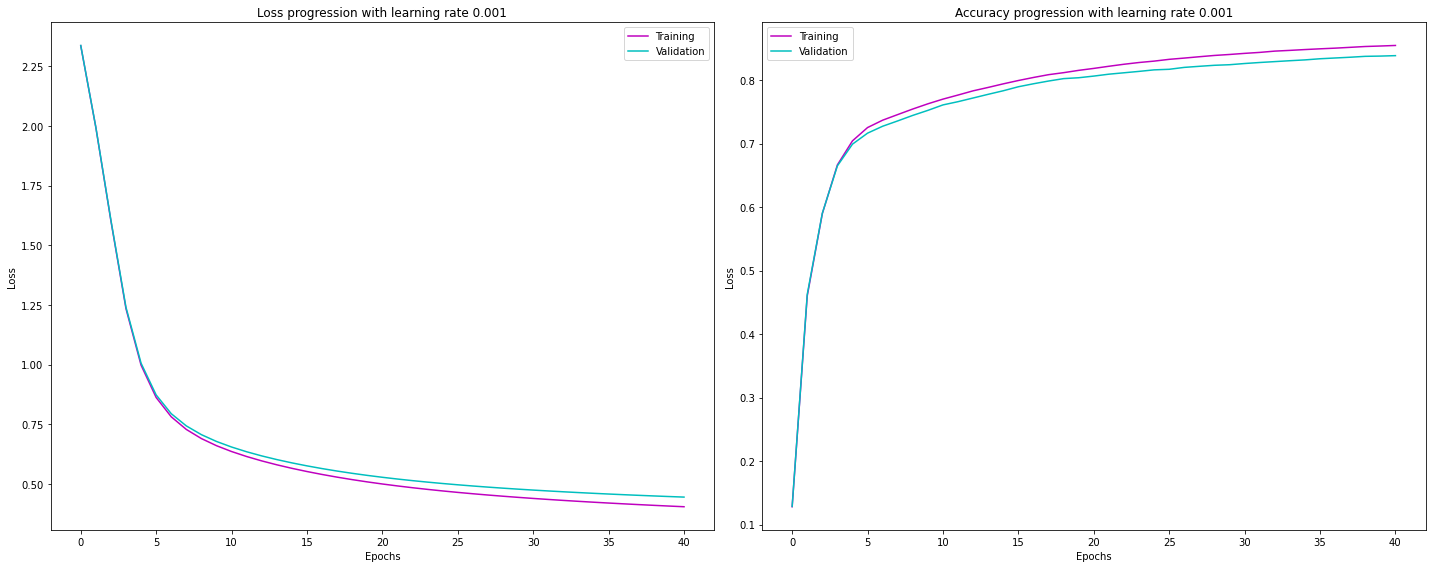

In [27]:
#plot losses after each epoch
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(np.arange(0, 41), train_ls1, color = 'm', label = 'Training')
ax.plot(np.arange(0, 41), val_ls1, color = 'c', label = 'Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title("Loss progression with learning rate 0.001")
ax.legend()
#plot accuracy fter each epoch
ax2.plot(np.arange(0, 41), train_as1, color = 'm', label = 'Training')
ax2.plot(np.arange(0, 41), val_as1, color = 'c', label = 'Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title("Accuracy progression with learning rate 0.001")
ax2.legend()
plt.tight_layout()

1.1.2

We repeat the previous part but now change the learning rate to $10^{-5}$ and $10^{-1}$ to see if this will alter the performance of the model.

In [29]:
train_ls2, val_ls2, train_as2, val_as2 = mlp_numpy(x_train, y_train, x_test, y_test, 256, 1e-5, 40)
train_ls3, val_ls3, train_as3, val_as3 = mlp_numpy(x_train, y_train, x_test, y_test, 256, 1e-1, 40)

Again, we plot the loss and accuracies of these models for both training and test sets at each epoch.

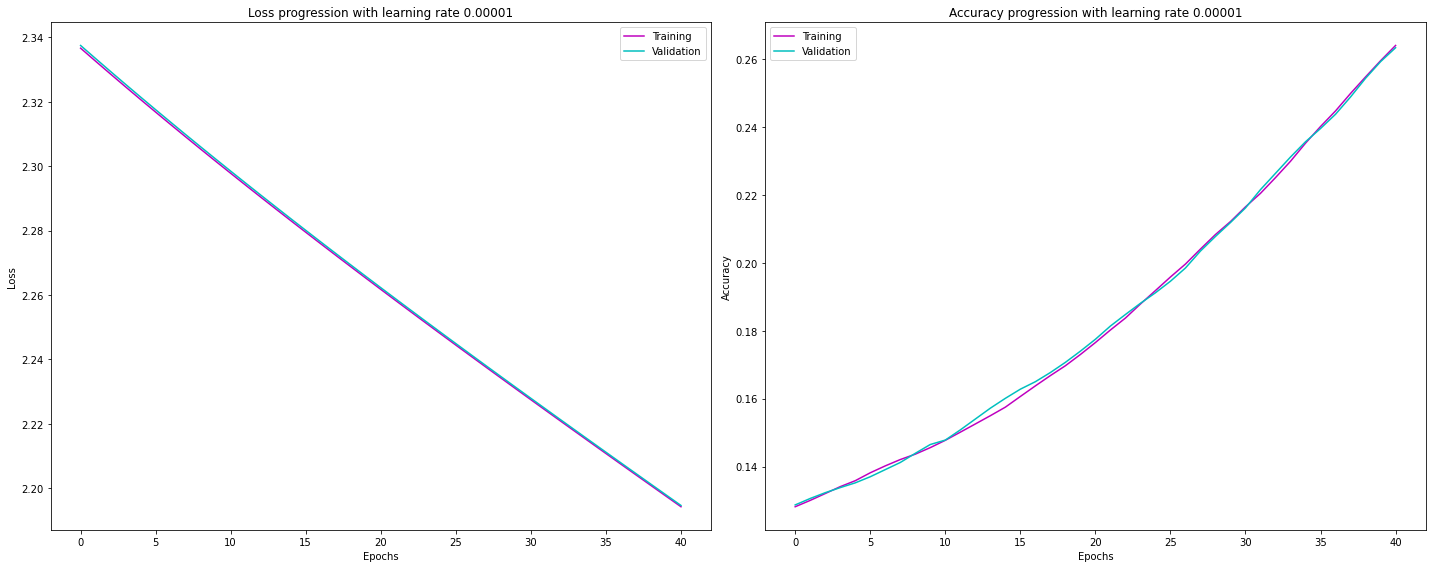

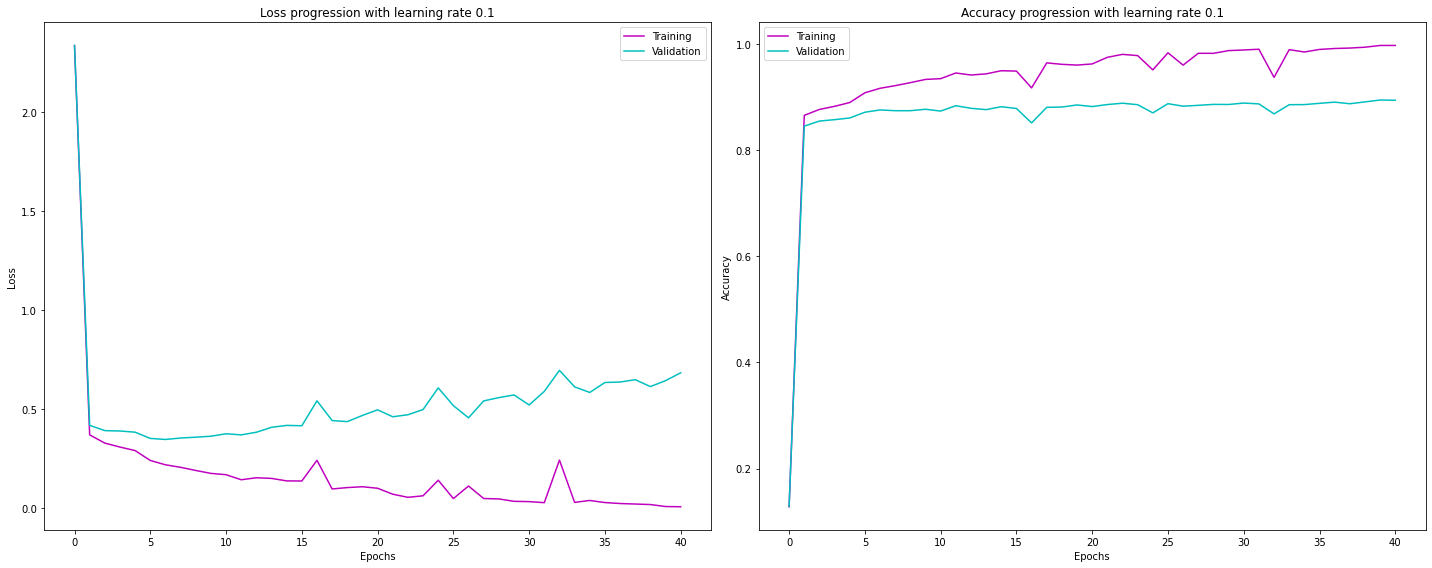

In [30]:
#plot losses after each epoch
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(np.arange(0, 41), train_ls2, color = 'm', label = 'Training')
ax.plot(np.arange(0, 41), val_ls2, color = 'c', label = 'Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title("Loss progression with learning rate 0.00001")
ax.legend()
#plot accuracy after each epoch
ax2.plot(np.arange(0, 41), train_as2, color = 'm', label = 'Training')
ax2.plot(np.arange(0, 41), val_as2, color = 'c', label = 'Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title("Accuracy progression with learning rate 0.00001")
ax2.legend()
plt.tight_layout()
#plot losses after each epoch
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(np.arange(0, 41), train_ls3, color = 'm', label = 'Training')
ax.plot(np.arange(0, 41), val_ls3, color = 'c', label = 'Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title("Loss progression with learning rate 0.1")
ax.legend()
#plot accuracy fter each epoch
ax2.plot(np.arange(0, 41), train_as3, color = 'm', label = 'Training')
ax2.plot(np.arange(0, 41), val_as3, color = 'c', label = 'Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.set_title("Accuracy progression with learning rate 0.1")
ax2.legend()
plt.tight_layout()

Firstly, we comment on the performance and convergence of loss of the model in 1.1.1. The plots show that the training and testing convergence of loss is near identical as well as the accuracy. We see a smooth convergence of the loss to a value of 0.5 and accuracy to a value of 0.85. This values show very that this model performs very well, specifically the training set curves show that the model learns well and the validation curves show that the model generalizes well. The smooth increase in the validation curve also shows that the learning rate of $10^{-3}$ is one that does not invoke overfitting of the model. <br />
With the two new learning rates we observe two common trends in MLPs. We see that with a rate of $10^{-5}$ we have again have near identical training and validation curves like in 1.1.1 and also with smooth convergence of loss and accuracy but the loss only reaches 2.2 and the accuracy reaches 0.26, which clearly is not good performance. Since the learning rate has been reduced, we have that this model learns much slower and so does not generalise well as the model training is not decent enough to understand the intricacies of the image data. This is a good example of underfitting. Hence, we may state that $10^{-5}$ is too low a learning rate. <br /> With a learning rate of $10^{-1}$ we see the opposite effect, namely overfitting. Although the training loss keeps decreasing slowly after 3 epochs showing that the model is still learning well, the loss of the validation set begins to increase which means that we have overfitting and poor generalization. After the sharp jump in 3 epochs the accuracy for the training data grows slowly to near 1 but the validation accuracy stays more or less constant. So we could better this model by implementing early stopping after about 5 epochs. We note the interserting observation of increasing validation loss after 3 epochs but constant validation accuracy. This is a result of the cross entropy function we use as our loss. Poor predictions are penalised by the logarithm much more that it rewards good predictions. So the loss and accuracy are not inversely correlated.<br /> 
In conclusion we may infer that a learning rate of $10^{-5}$ is too low and invokes underfitting, a learning rate of $10^{-1}$ is too high and invokes overfitting and a learning rate of $10^{-3}$ gives a good fitting model.

1.1.3

We train another MLP model with the same learning rate of $10^{-3}$ as in 1.1.1 but now train for 80 epochs instead of 40.

In [31]:
train_ls4, val_ls4, train_as4, val_as4 = mlp_numpy(x_train, y_train, x_test, y_test, 256, 1e-3, 80, printing=True)

Initialisation 
 Training loss: 2.3366269232643857,  Validation loss: 2.3374677070455845, Training accuracy: 0.12816666666666668, Validation accuracy 0.1287
Epoch 1 
 Training loss: 1.9943404170510892, Validation loss: 1.9953496636009092, Training accuracy: 0.46018333333333333, Validation accuracy: 0.4625
Epoch 2 
 Training loss: 1.6022421488387621, Validation loss: 1.605473783549044, Training accuracy: 0.5898, Validation accuracy: 0.5904
Epoch 3 
 Training loss: 1.2339300742355548, Validation loss: 1.2397600144075407, Training accuracy: 0.6666333333333333, Validation accuracy: 0.6651
Epoch 4 
 Training loss: 0.9973275925329608, Validation loss: 1.005640300951582, Training accuracy: 0.7044833333333334, Validation accuracy: 0.6993
Epoch 5 
 Training loss: 0.8618083695106206, Validation loss: 0.8726242550269655, Training accuracy: 0.7254333333333334, Validation accuracy: 0.7166
Epoch 6 
 Training loss: 0.7810006293995718, Validation loss: 0.7940143863935515, Training accuracy: 0.73703333

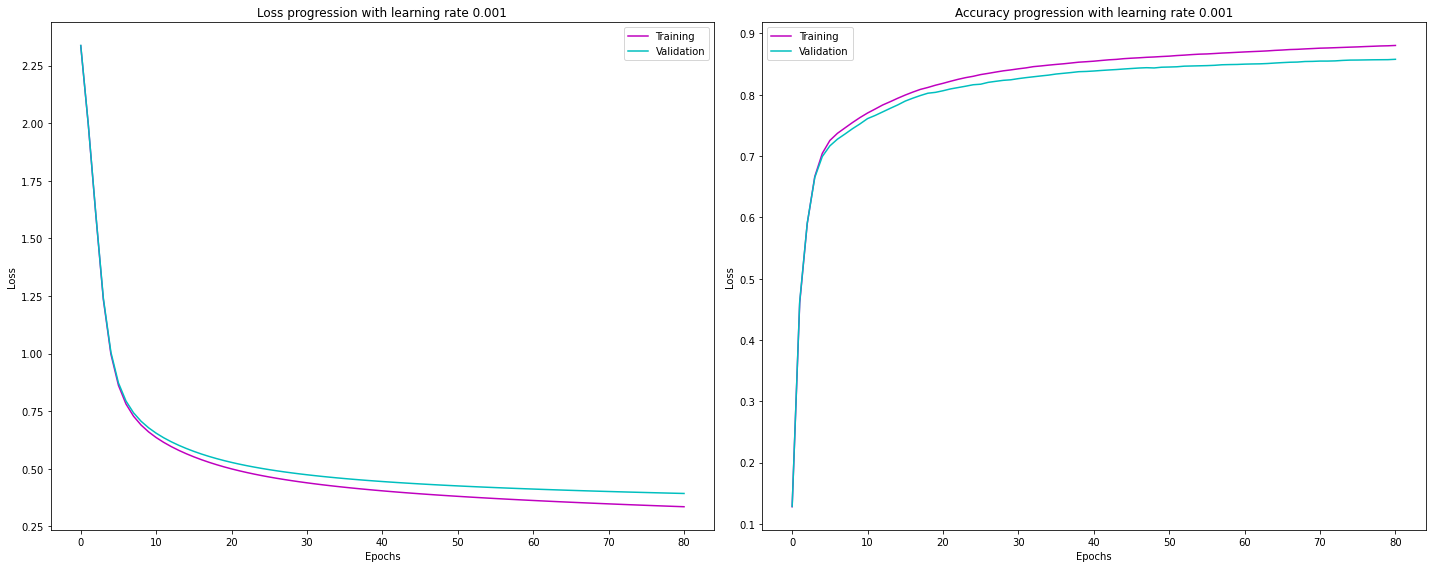

In [32]:
#plot losses after each epoch
f = plt.figure(figsize=(20,8))
ax = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax.plot(np.arange(0, 81), train_ls4, color = 'm', label = 'Training')
ax.plot(np.arange(0, 81), val_ls4, color = 'c', label = 'Validation')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title("Loss progression with learning rate 0.001")
ax.legend()
#plot accuracy fter each epoch
ax2.plot(np.arange(0, 81), train_as4, color = 'm', label = 'Training')
ax2.plot(np.arange(0, 81), val_as4, color = 'c', label = 'Validation')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title("Accuracy progression with learning rate 0.001")
ax2.legend()
plt.tight_layout()

In [37]:
print(val_as4[-1]-val_as1[-1])
print(val_ls1[-1]-val_ls4[-1])

0.019100000000000006
0.05181328075793362


We saw in the previous part that using a learning rate of $10^{-3}$ gives a good fitting model. So again with 80 epochs we have a good fitting model with good generalisability and it learns well. We observe that after 40 epochs we tend to a plateau. This is due to the nature of SGD. We have a found a local minima in training and so cannot escape it by the SGD algorithm. The validation set also begins to plateua since the trainable parameters will not be updated muh due to the local minima found in SGD. We can conclude that the additional 0.02 accuracy in validation and reduction of 0.05 in the validation loss is not worth nearly doubling the computational time (166min/88min = 1.89) by the following calculations. We take the final values for loss and accuracy for both the training and validation data and divide them by the number of epochs used in the model. We clearly observe that the proportion of final loss and final accuracy for both training and validation sets per epoch is twice as large in the model from 1.1.1.

In [61]:
comp = [["40 epochs", train_ls1[-1]/40, train_as1[-1]/40, val_ls1[-1]/40, val_as1[-1]/40],
["80 epochs", train_ls4[-1]/80, train_as4[-1]/80, val_ls4[-1]/80, val_as4[-1]/80]]
print(tabulate(comp, headers=["","Training Loss / Epoch", "Training Accuracy / Epoch", "Validation Loss / Epoch", "Validation Accuracy / Epoch"]))


             Training Loss / Epoch    Training Accuracy / Epoch    Validation Loss / Epoch    Validation Accuracy / Epoch
---------  -----------------------  ---------------------------  -------------------------  -----------------------------
40 epochs               0.0100982                     0.0213683                 0.0111086                       0.0209675
80 epochs               0.00418656                    0.0110046                 0.00490665                      0.0107225


<a name="q12"></a>
## 1.2 Convolutional neural network (CNN) [^](#outline)

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
import tensorflow as tf
tf.device('/device:GPU:0')

In [ ]:
# Load the data into tf.data.Dataset objects
train_dataset = tf.data.Dataset.from_tensor_slices((x_train[...,np.newaxis], y_train)) 
test_dataset = tf.data.Dataset.from_tensor_slices((x_test[...,np.newaxis], y_test))

# Shuffle the training dataset

train_dataset = train_dataset.shuffle(buffer_size = 60000)

# Batch the training and test datasets

train_dataset = train_dataset.batch(batch_size = 256)
test_dataset = test_dataset.batch(batch_size = 256)

1.2.1

We will use the specialised ML library TensorFlow to implement a convolutional neural network (CNN), with 5 hidden layers in total. The first 4 will be convolutional and the last hidden layer will be fully-connected, also known as dense. The first 2 will use 8 feature maps and the last two will use 16 feature maps. The last convolutional layer will be followed by a 2 ✕ 2 maximum pooling layer. The dense layer will have 64 neurons, and will be followed by the output layer with 10 neurons. Again, we use the LeakyReLU activation with a slope of 0.01 between all layers and the final layer will have softmax activation again. We choose the optimisation and loss the same as in the numpy implementation. The full architecture of the layers is given in the model summaries.
We now define a function to build our CNN.

In [ ]:
#Build the model
def get_model():
    model = Sequential([
        Conv2D(8, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape = (28, 28, 1), name = "Conv2D_1"),
        Conv2D(8, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Conv2D_2"),
        Conv2D(16, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Conv2D_3"),
        Conv2D(16, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Conv2D_4"), 
        MaxPool2D((2, 2), name = "MaxPool2D"),
        Flatten(name="Flatten"),
        Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Dense_1"),
        Dense(10, activation='softmax', name = "Output")
    ], name='fashion_mnist_classifier')
    return model


We can see the architecture of the model from the summary below.

In [ ]:
fashion_mnist_model = get_model()
fashion_mnist_model.summary()

Model: "fashion_mnist_classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_1 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 Conv2D_2 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 Conv2D_3 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 Conv2D_4 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 MaxPool2D (MaxPooling2D)    (None, 10, 10, 16)        0         
                                                                 
 Flatten (Flatten)           (None, 1600)              0         
                                                                 
 Dense_1 (Dense)             (None, 64)   

Now we are ready to compile and train the model.

In [ ]:
# Compile and train the model
fashion_mnist_model = get_model()
fashion_mnist_model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3), metrics=['accuracy'])
history = fashion_mnist_model.fit(train_dataset, validation_data = test_dataset, epochs = 40, verbose=True)

Epoch 1/40
235/235 [==============================] - 14s 21ms/step - loss: 2.2988 - accuracy: 0.1712 - val_loss: 2.2962 - val_accuracy: 0.1772
Epoch 2/40
235/235 [==============================] - 5s 21ms/step - loss: 2.2941 - accuracy: 0.2051 - val_loss: 2.2916 - val_accuracy: 0.2378
Epoch 3/40
235/235 [==============================] - 5s 20ms/step - loss: 2.2886 - accuracy: 0.2586 - val_loss: 2.2848 - val_accuracy: 0.2865
Epoch 4/40
235/235 [==============================] - 5s 20ms/step - loss: 2.2796 - accuracy: 0.2981 - val_loss: 2.2729 - val_accuracy: 0.3167
Epoch 5/40
235/235 [==============================] - 5s 20ms/step - loss: 2.2616 - accuracy: 0.3253 - val_loss: 2.2460 - val_accuracy: 0.3429
Epoch 6/40
235/235 [==============================] - 6s 22ms/step - loss: 2.2113 - accuracy: 0.3548 - val_loss: 2.1543 - val_accuracy: 0.3697
Epoch 7/40
235/235 [==============================] - 6s 26ms/step - loss: 1.9517 - accuracy: 0.4040 - val_loss: 1.5870 - val_accuracy: 0.531

We plot the loss function and accuracy for the model over the epoch progression. We have a quite successful model in that we reach around 0.8 accuracy for the test data and loss is reduced to about 0.5. We observe smooth training loss and accuracy convergence which suggests an adequate value for the learning rate (1e-3) even at later epochs, so we do not need to implement a common technique of adjusting the learning rate over epochs. A main observation that we see is a common theme among these sorts of deep learning models which is overfitting. After approximately epoch 30, the validation loss begins to behave erratically, just like the the validation accuracy which jumps down by 0.1 before jumping back up and down for 10 epochs. The key difference between this model and the MLP in 1.1.1 is that this model overfits and the MLP is a good fit (already discussed why this is true in previous parts). We also see slightly different shapes in the curves. Regarding training loss curves, for the MLP we have a steep gradient straight away before it levels out whereas for this CNN model we have an initial flat curve for about 5 epochs before the curve starts to look very similar in shape to the MLP but only reaches 0.5 loss vs 0.4 for the MLP. The training accuracy curves are very similar too, with only a slightly less initially smooth curve for the CNN and a slightly smaller final value of 0.81 vs 0.85 for the MLP. So far we have observed that both of these models learn very well. However, they certainly do not generalize as well as one another. We saw good generalisation for the MLP previuously but the same cannot be said for the CNN. The CNN begins to have a highly fluctuating pattern around midway through training in both accuracy and loss and results in a lower accuracy of 0.80 vs 0.84 and higher loss of 0.56 vs 0.44. So altogether, the CNN has worse optimization, accuracy and generalisability performance than the MLP. It also, unlike the MLP, begins to overfit on the data. This is precisely what we will combat in the next part with a regularisation-like technique.

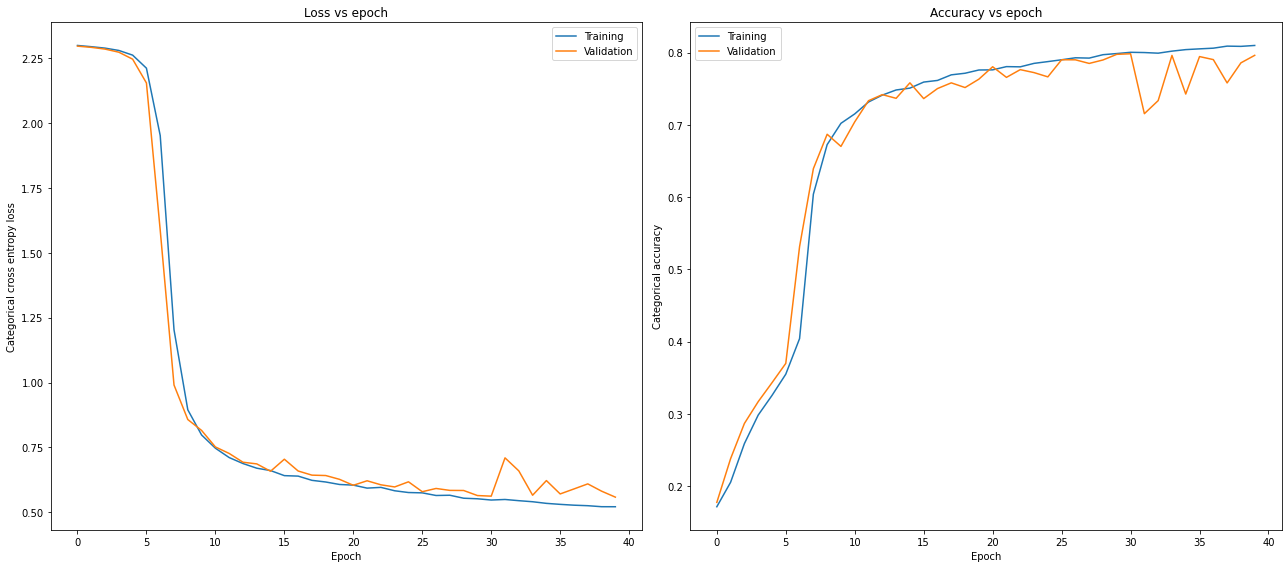

In [ ]:
fig = plt.figure(figsize=(18,8))
fig.add_subplot(121)
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()
fig.add_subplot(122)
plt.plot(history.history['accuracy'],label = "Training")
plt.plot(history.history['val_accuracy'], label = "Validation")
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()
plt.tight_layout()

1.2.2

We now seek to implement a regularisation-like technique to prevent this overfitting. The idea of dropout is to modify the behaviour of neurons within the network. Large networks are slow to use and so it becomes not feasible to work against overfitting by combining predictions of many different neural nets at a time. With dropout we null certain units and their connections during training. This stops the over-co-adaptation of units in a bid to increase generalisability. During training, dropout samples from an exponential number of thinned networks. When running the model on the test data it is simple to approximate the effect of averaging the predictions of these thinned networks by using a sole unthinned network with smaller weights. This drastically reduces overfitting and we also have a decrease in storage of parameters.

With dropout we randomly 'null' neurons during training according to a bernoulli mask that is independent at each iteration. Let $W^k \in \mathbb{R}^{n_{k+1}\times n_k}$ be a weight matrix mapping neurons in layer $k$ to $k+1$ then we can view dropout as $$W^k \leftarrow W^k ⋅ diag([z_{k,j}]^{n_{k-1}}_{j=1}$$ $$z_{k,j} \sim Bern(p_k) \quad k = 1,...,L$$

We will incorporate Dropout in the fully connected layer. But dropout requires a use of hyper-parameter (namely the dropout rate) which we will tune now. We do this by using 80% of the training set for the
actual training and 20% f the training set as a validation set. We scan over a suitable range of the dropout
probability $[0.1, 0.9]$ in steps of 0.1 to find an optimal value of this dropout probability, using
accuracy on the validation set as the measure of performance for this search.

In [ ]:
# Load the data into tf.data.Dataset objects
#extract the train test split from training data for optimising the dropout rate
dropx_train = x_train[:int(0.8*len(x_train))]
dropx_test = x_train[int(0.8*len(x_train)):]
dropy_train = y_train[:int(0.8*len(x_train))]
dropy_test = y_train[int(0.8*len(x_train)):]
trainsetdata = tf.data.Dataset.from_tensor_slices((dropx_train[...,np.newaxis], dropy_train)) 
valsetdata = tf.data.Dataset.from_tensor_slices((dropx_test[...,np.newaxis], dropy_test))

# Batch the training and test datasets
trainset = trainsetdata.batch(batch_size = 256)
valset = valsetdata.batch(batch_size = 256)

In the original paper regarding dropout, it is suggested to implement dropout on (which in the tensorflow formulation is below) fully connected layers just before the output. We can see that dropout should not be implemented on the convolutional layers since these layers produce informative 2D activation maps that encode key spacial features in the image.

In [ ]:
#Build the model
def get_reg_model(rate):
    model = Sequential([
        Conv2D(8, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), input_shape = (28, 28, 1), name = "Conv2D_5"),
        Conv2D(8, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Conv2D_6"),
        Conv2D(16, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Conv2D_7"),
        Conv2D(16, (3,3), activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Conv2D_8"), 
        MaxPool2D((2, 2), name = "MaxPool2D_1"),
        Flatten(name = "Flatten_1"),
        Dense(64, activation=tf.keras.layers.LeakyReLU(alpha=0.01), name = "Dense_2"),
        Dropout(rate,  name = "Dropout"), #new layer
        Dense(10, activation='softmax', name = "Output_1")
    ], name='fashion_mnist_classifier_dropout')
    return model

In [ ]:
get_reg_model('rate').summary()

Model: "fashion_mnist_classifier_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv2D_5 (Conv2D)           (None, 26, 26, 8)         80        
                                                                 
 Conv2D_6 (Conv2D)           (None, 24, 24, 8)         584       
                                                                 
 Conv2D_7 (Conv2D)           (None, 22, 22, 16)        1168      
                                                                 
 Conv2D_8 (Conv2D)           (None, 20, 20, 16)        2320      
                                                                 
 MaxPool2D_1 (MaxPooling2D)  (None, 10, 10, 16)        0         
                                                                 
 Flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 Dense_2 (Dense)             (None

In [ ]:
#scan over suitable dropout rates
def get_opt_rate():
    accuracy = []
    fig = plt.figure(figsize=(20,8))
    for i in range(1,10):
        model = get_reg_model(i/10)
        model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3), metrics=['accuracy'])
        history = model.fit(trainset, validation_data = valset, epochs = 40, verbose = False)
        acc = history.history['val_accuracy'][-1]
        accuracy.append(acc)
        print(f"Validation accuracy after 40 epochs is {acc} for a dropout rate of {i/10}")
        plt.plot(history.history['val_accuracy'], label = f"Dropout rate {i/10}")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Categorical accuracy")
    plt.title("Validation Accuracy vs Epoch")
    plt.show()
    return np.arange(0.1,1,0.1)[np.argmax(accuracy)]

We are now ready to scan for the optimal dropout rate.

Validation accuracy after 40 epochs is 0.8062499761581421 for a dropout rate of 0.1
Validation accuracy after 40 epochs is 0.7914166450500488 for a dropout rate of 0.2
Validation accuracy after 40 epochs is 0.7729166746139526 for a dropout rate of 0.3
Validation accuracy after 40 epochs is 0.7714999914169312 for a dropout rate of 0.4
Validation accuracy after 40 epochs is 0.7820833325386047 for a dropout rate of 0.5
Validation accuracy after 40 epochs is 0.7740833163261414 for a dropout rate of 0.6
Validation accuracy after 40 epochs is 0.7601666450500488 for a dropout rate of 0.7
Validation accuracy after 40 epochs is 0.7462499737739563 for a dropout rate of 0.8
Validation accuracy after 40 epochs is 0.7428333163261414 for a dropout rate of 0.9


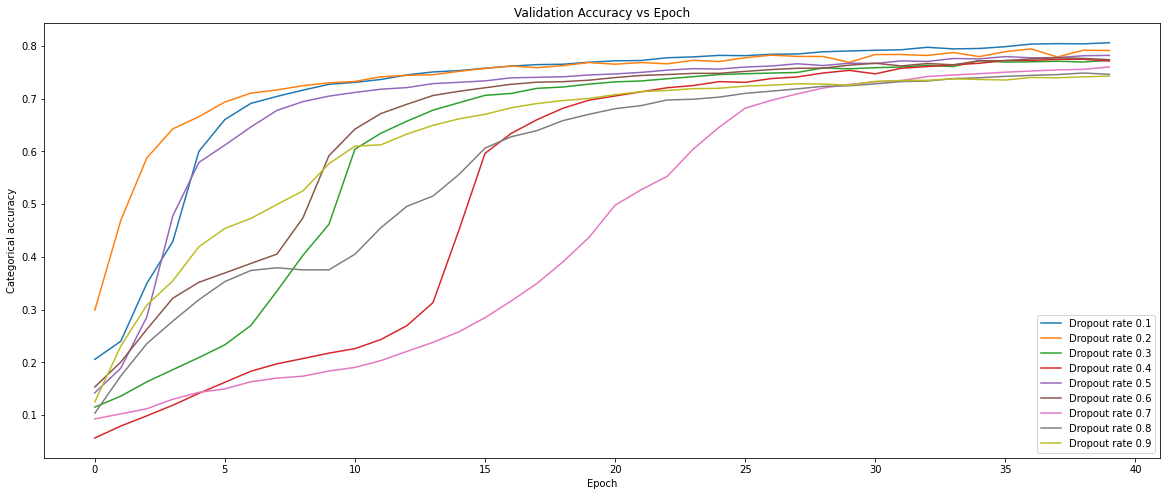

In [ ]:
opt_rate = get_opt_rate()

We observe that the optimal dropout rate is 0.1 as this gives maximal accuracy from the setting described above.

Now that we have the optimal dropout rate we retrain the CNN with this dropout rate incorporated.

In [ ]:
#Compile and train the model with optimal rate
start = time.time()
fashion_mnist_model_opt = get_reg_model(opt_rate)
fashion_mnist_model_opt.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=tf.keras.optimizers.SGD(learning_rate = 1e-3), metrics=['accuracy'])
history_opt = fashion_mnist_model_opt.fit(train_dataset, validation_data = test_dataset, epochs = 40, verbose=True)
end = time.time()
time_cnn = end - start

Epoch 1/40
235/235 [==============================] - 5s 19ms/step - loss: 2.3033 - accuracy: 0.0639 - val_loss: 2.2995 - val_accuracy: 0.0871
Epoch 2/40
235/235 [==============================] - 4s 19ms/step - loss: 2.2971 - accuracy: 0.1033 - val_loss: 2.2944 - val_accuracy: 0.1141
Epoch 3/40
235/235 [==============================] - 5s 19ms/step - loss: 2.2922 - accuracy: 0.1292 - val_loss: 2.2898 - val_accuracy: 0.1344
Epoch 4/40
235/235 [==============================] - 4s 19ms/step - loss: 2.2873 - accuracy: 0.1498 - val_loss: 2.2845 - val_accuracy: 0.1540
Epoch 5/40
235/235 [==============================] - 4s 18ms/step - loss: 2.2814 - accuracy: 0.1662 - val_loss: 2.2779 - val_accuracy: 0.1717
Epoch 6/40
235/235 [==============================] - 4s 18ms/step - loss: 2.2737 - accuracy: 0.1833 - val_loss: 2.2686 - val_accuracy: 0.1874
Epoch 7/40
235/235 [==============================] - 4s 18ms/step - loss: 2.2623 - accuracy: 0.1957 - val_loss: 2.2543 - val_accuracy: 0.1944

We compare the new model with optimal dropout with the same CNN without dropout. In the two training curves we see a resemblance. In both, the dropout CNN looks the the CNN without dropout shifted to the right, almost lagging behind by around 5 epochs. For the loss function both initially are flat but the dropout CNN stays flatter for longer. This is because with the dropout the inital optimising direction takes more time to reach due to the number of zeroed neurons which provide no pass of learned information. This is the same reason that provides similar behaviour in the accuracy. We note that the training loss is slightly worse with dropout as is the training accuracy. But this is what we expected as we have less connections between layers and so less learning can occur. However, we see that dropout has worked precisely as we wanted when observing the differences in validation set curves. With dropout, we have much smoother convergence in loss and accuracy and achieve better final loss (0.5464 vs 0.5587) and better accuracy performance (0.8027 vs 0.7963). In other words, we have removed the overfitting and made this model good fitting with increased generalisability. The payoff between slightly worse learning and increased generalisability is of course a worthwhile one as in the end goal we seek to have a model that can perform well on many different data sets.

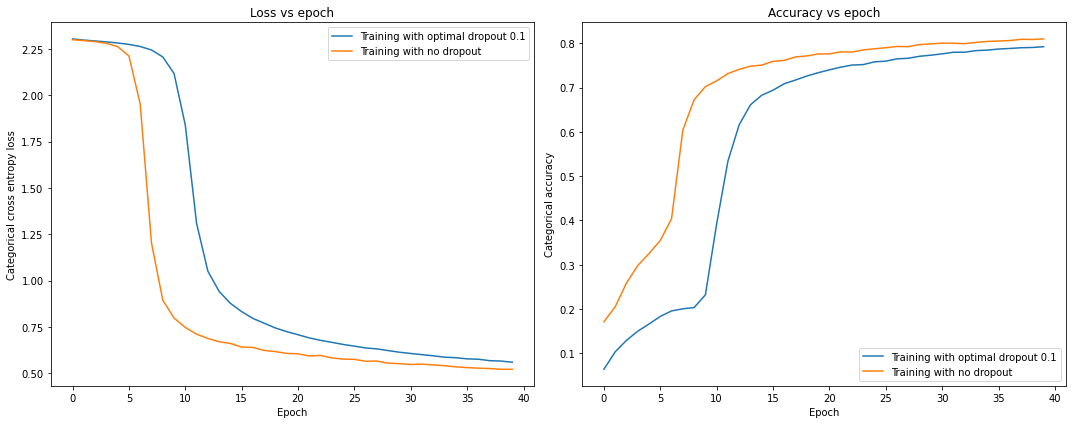

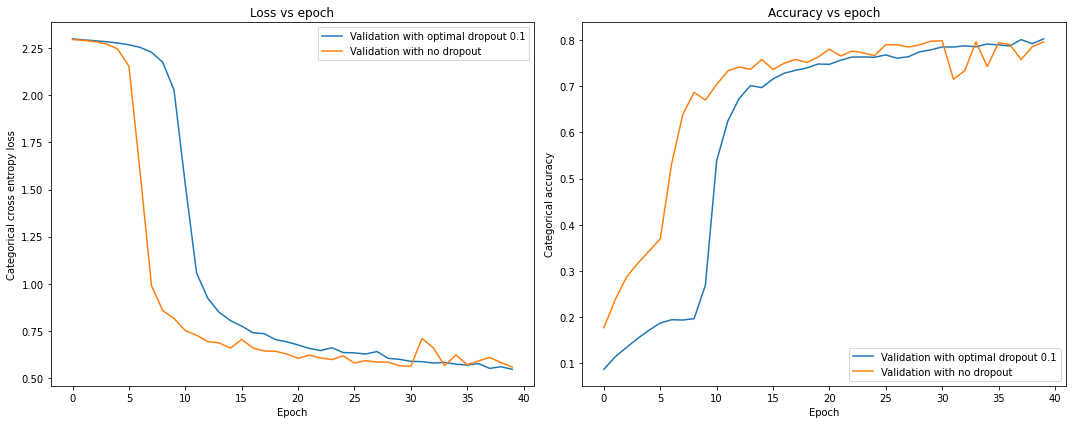

In [ ]:
fig = plt.figure(figsize=(15,6))
fig.add_subplot(121)
plt.plot(history_opt.history['loss'], label = f'Training with optimal dropout {opt_rate}')
plt.plot(history.history['loss'], label = 'Training with no dropout')
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()
fig.add_subplot(122)
plt.plot(history_opt.history['accuracy'],label = f'Training with optimal dropout {opt_rate}')
plt.plot(history.history['accuracy'],label = 'Training with no dropout')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()
plt.tight_layout()
fig = plt.figure(figsize=(15,6))
fig.add_subplot(121)
plt.plot(history_opt.history['val_loss'], label = f'Validation with optimal dropout {opt_rate}')
plt.plot(history.history['val_loss'], label = "Validation with no dropout")
plt.xlabel("Epoch")
plt.ylabel("Categorical cross entropy loss")
plt.title("Loss vs epoch")
plt.legend()
fig.add_subplot(122)
plt.plot(history_opt.history['val_accuracy'], label = f'Validation with optimal dropout {opt_rate}')
plt.plot(history.history['val_accuracy'], label = 'Validation with no dropout')
plt.xlabel("Epoch")
plt.ylabel("Categorical accuracy")
plt.title("Accuracy vs epoch")
plt.legend()
plt.tight_layout()

We now detail how the dropout affects the features learned by the dense layer. In the CNN without dropout the SGD derivatives received by each parameter informs it how it should change so reduced the final loss function, given what the other units are doing.
This sometimes results in units changing to fix the mistakes of others. As many units are connected to one another this could lead to co-adaptations provoking overfitting since these co-adaptations do not generalise for unseen data. We may suggest that in every hidden unit, dropout will stop the co-adaptation by having the presence of other hidden units unreliable. And so, these hidden units may not be reliant on these other connected units to rectify its own mistakes.

Now we will explore the effect of dropout on sparsity. We plot below the histograms for the activations of the hidden units of the dense layer when the model is evaluated on the test set for the model with and without optimal dropout. 

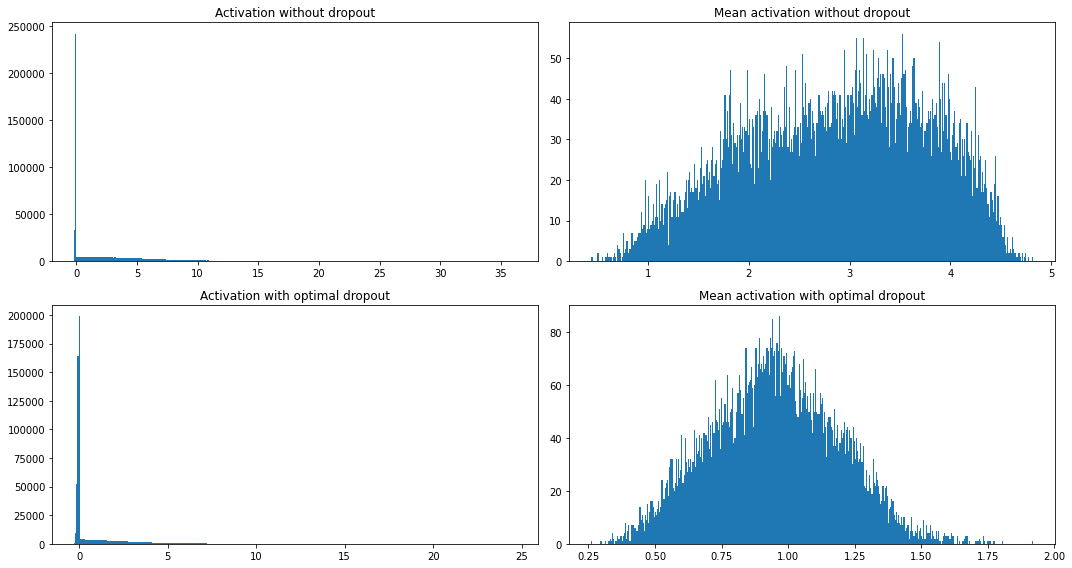

In [ ]:
from tensorflow.keras.models import Model
dense_feature = Model(inputs=fashion_mnist_model.inputs, outputs=fashion_mnist_model.get_layer('Dense_1').output)
activations = dense_feature.predict(x_test[...,np.newaxis])
mean_activations = np.mean(activations, axis=1)
dense_feature_opt = Model(inputs=fashion_mnist_model_opt.inputs, outputs=fashion_mnist_model_opt.get_layer('Dense_2').output)
activations_opt = dense_feature_opt.predict(x_test[...,np.newaxis])
mean_activations_opt = np.mean(activations_opt, axis=1)

nrow = 2; ncol = 2

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize = (15,8))

for i,ax in enumerate(axs.reshape(-1)): 
  if i == 0:
    ax.hist(activations.flatten(),bins=400)
    ax.set_title("Activation without dropout")
  if i == 1:
    ax.hist(mean_activations,bins=400)
    ax.set_title("Mean activation without dropout")
  if i == 2:
    ax.hist(activations_opt.flatten(),bins=400)
    ax.set_title("Activation with optimal dropout")
  if i == 3:
    ax.hist(mean_activations_opt,bins=400)
    ax.set_title("Mean activation with optimal dropout")
plt.tight_layout()

We notice that the activations of hidden units become sparser with dropout. Thus we may hypothesise that dropout has a side effect that leads to sparse representations. In good quality sparse models we should have just a few select highly activated units and on average the activation of any unit across all data should be small. <br />
We can see that we have fewer hidden units with high activations judging by the scale and greater mass towards 0 in the left hand side plot, when dropout is incorporated. Further, the mean activations are much lower with dropout (centred about 1 vs centred about 3). Hence, the two statements about good quality sparse models above are true when dropout is incorporated.

1.2.3

We now compare the results from the MLP model in 1.1. to the CNN with optimal dropout from 1.2.2. <br />
Both were trained over 40 epochs with the same learning rate of $10^{-3}$ with the same optimisation method of SGD and the same cross-entropy loss function.

In [ ]:
#print(time_cnn, history_opt.history['accuracy'][-1], history_opt.history['val_accuracy'][-1])

193.69690084457397 0.7923499941825867 0.8026999831199646


In [68]:
compare = [["", "Training Accuracy", "Validation Accuracy", "Computational Time", "Number of Parameters"],["Numpy MLP", train_as1[-1], val_as1[-1], time_mlp, 959610],["Tensorflow CNN", 0.7923499941825867,0.8026999831199646,193.69690084457397 ,107266]]
print(tabulate(compare,headers='firstrow'))

                  Training Accuracy    Validation Accuracy    Computational Time    Number of Parameters
--------------  -------------------  ---------------------  --------------------  ----------------------
Numpy MLP                  0.854733                 0.8387              5285.57                   959610
Tensorflow CNN             0.79235                  0.8027               193.697                  107266


Importantly both models do not underfit or overfit and generalize well. The difference is that just the learning rate being adequate enough in the MLP guaranteed a good fitting model whereas with the same learning rate the CNN had the issue of overfitting. With an added dropout layer the CNN was regularised, hence sacrificing a litte training accuracy for a great improvement in validation accuracy, although not enough to match that of the Numpy MLP. This means that for both training and validation accuracy the MLP performs better. So we could be inclined to declare it the better model. However, the far more drastic difference is in computational efficiency and storage. The CNN is compatible with use of the Google Colab GPU, which runs parallel computation, and so the time to train the Tensorflow CNN was just over 3 minutes which is over 27 times faster than the Numpy MLP which cannot benefit from parallel proccessing. Further, the CNN architecture has 9 times less parameters than the MLP, since we are using small convolutional layers in the CNN in comparison to much bigger dense layers in the MLP, meaning a huge reduction in storage using the CNN. Overall, the practicality of the CNN far outweighs having slightly worse accuracies than the MLP and so we can conclude that in industry or research the CNN would be preferred.

1.2.4

Note to the reader: <br />
I was running my CNN code in google colab to speed up time with a GPU. However, I eventually ending up running out of GPU use and so I could not run the code for 1.2.4 as switching the hardware accelerator removes all saved variables. Luckily I had rand 1.2.4 in a separate notebook before hand and so I will use the output from that here. Unfortunately, you cannot copy and paste notebook cells with the output so I have had to save the output and load it here as an image. This is why some the channel names are different as in this notebook I had not named them yet. The code does not differ.

We now want to visualise the effects of feature maps on one of the images from the data set.

We choose the first image which happens to be a boot.

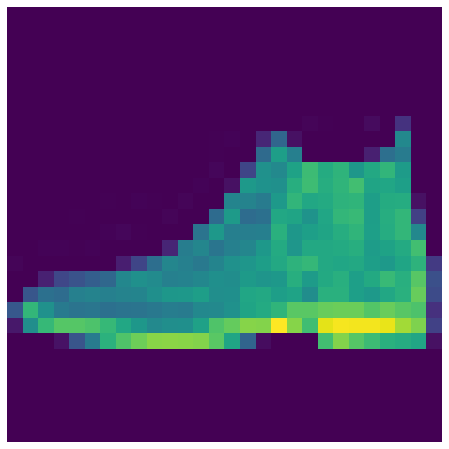

In [41]:

image = x_test[0]
plt.figure(figsize=(8, 8))
plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
# Define the multi-output model
from tensorflow.keras.models import Model
inputs = fashion_mnist_model_opt.inputs
layer_names = ['conv2d_48', 'conv2d_49', 'conv2d_50', 'conv2d_51']
outputs = [fashion_mnist_model_opt.get_layer(layer_name).output for layer_name in layer_names]
fmn_features = Model(inputs=inputs, outputs=outputs)

In [ ]:
# View the model inputs and outputs Tensors
fmn_features.inputs
fmn_features.outputs

In [ ]:
# Extract the hierarchical features for this image
features = fmn_features(image[tf.newaxis, ...])
features = [image] + features

In [ ]:
# Visualise the features

import numpy as np

n_rows, n_cols = 1, 5
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 14))
fig.subplots_adjust(hspace=0.05, wspace=0.2)

for i in range(len(features)):
    feature_map = features[i]
    num_channels = feature_map.shape[-1]
    row = i // n_cols
    col = i % n_cols
    if i == 0:
        axes[col].imshow(image)
        axes[col].set_title('Original image')
    else:
        random_feature = np.random.choice(num_channels)
        axes[col].imshow(feature_map[0, ..., random_feature])
        axes[col].set_title('{}, channel {} of {}'.format(layer_names[i-1], random_feature + 1, num_channels))
        
    axes[col].get_xaxis().set_visible(False)
    axes[col].get_yaxis().set_visible(False)
plt.show()

We randomly choose a feature map from each convolutional layer and visualise it. We see that the first feature map extracts the overall shape of the item, i.e where there is colouring and where there is not which is why it looks a quite similar to the orginal. The second feature extracts the background of the item which is why it looks like the inverse colouring of the original image. The third feature map extracts similar features to the previous one but extracts the background in a more general and so less detailed manner which is why it looks more blurred than the previous image. This is something we expect of feature maps as we enter the later layers. The final layers tend to extract more general features. This is further supported by the last feature map selecting the a vague idea of the top and bottom boundary of the shoe but as we see it is extremely general by the blurriness of the final image.

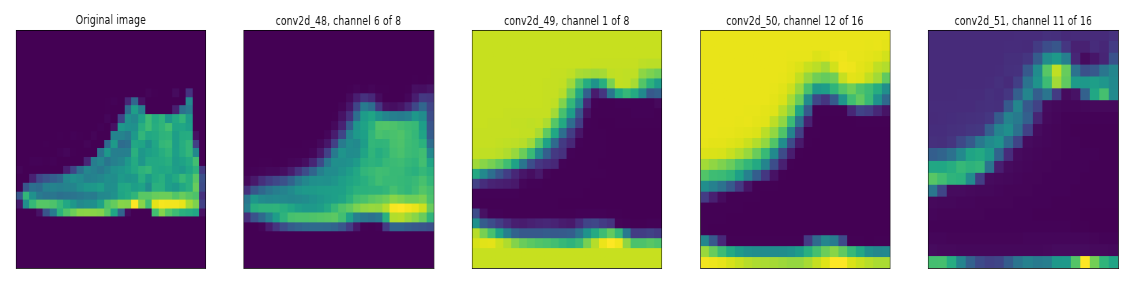

In [57]:
# Load the output from google colab cell
import matplotlib.image as mpimg
img = mpimg.imread("./feature_maps_colab.png")
plt.figure(figsize = (20,5))
plt.imshow(img, aspect='auto')
plt.axis("off")
plt.show()

<a name="task-2"></a>

# Task 2: Unsupervised learning [^](#outline)

<a name="q21"></a>

## 2.1 Dimensionality reduction and clustering of a subset of  the Fashion-MNIST image data [^](#outline)

In this question we will explore some dimensionality reduction and clustering techniques as the the first chapter of the unsupervised learning part in this report.

2.1.1

We extract the first 1000 images from the Fashion-MNIST data set from Task 1.

In [90]:
#get first 1000 images
X = x_test[:1000]

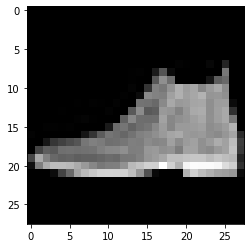

In [91]:
# plot the first image to verify extraction
plt.figure(figsize=(4,4))
plt.imshow(X[0].reshape(28,28), cmap='gray');

We define a function to feature scale the data.

In [92]:
def standardise(X):
    mu = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    std_filled = std.copy()
    std_filled[std==0] = 1.
    Xbar = ((X-mu)/std_filled)
    return Xbar

The reason we feature scale while performing Principal Component Analysis (PCA) is because PCA attempts to select the features with largest variance. Since variance is larger for features with largers scales, PCA will unfairly be dominated by high magnitude features if not scaled. Further, just like for many supervised learning methods, feature scaling is necessary for k means clustering for the same reason: K means clustering uses the euclidean distance metric which will be unfairly dominated by features with high magnitudes. <br />
The reason we centre the data is to simplify calculation in the PCA algorithm. In the algorithm we are interested in finding the eigenvectors and eignvalues of the sample covariance matrix. If we centre our data the calculation for the finding the sample covariance becomes $$C=\frac{1}{N-1}X^TX$$

In [93]:

X = X.reshape(-1, 28*28) #reshape to flat images to be able to standardise
X = standardise(X)
X = X - np.ones((1000,1)) @ np.ones((1,1000)) @ X / 1000


We define the PCA algorithm function

In [94]:
def pca_function(X,k):

    # create covariance matrix S
    C = 1.0/(len(X)-1) * np.dot(X.T, X)


    # compute eigenvalues and eigenvectors using the eigsh scipy function
    eigenvalues, eigenvectors = linalg.eigsh(C, k, which="LM", return_eigenvectors=True) 

    # sorting the eigenvectors and eigenvalues from largest to smallest eigenvalue
    sorted_index = np.argsort(eigenvalues)[::-1]
    eigenvalues=eigenvalues[sorted_index]
    eigenvectors=eigenvectors[:,sorted_index ]

    # transform our data
    X_pca = X.dot(eigenvectors)

    return X_pca, eigenvectors, eigenvalues

2.1.2

We will now compute the top 25 principal components in order to gain an insight as to what the optimal value for the reduced dimension could be.

In [95]:
# choose our number of principle components
k = 25
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,k) 
eigenvalues

array([177.15423179, 109.86764551,  43.5554128 ,  39.19086755,
        32.59168756,  24.48016045,  22.45760293,  18.44310565,
        15.64466596,  12.04474225,   8.97757677,   8.0343039 ,
         7.33801024,   7.16195031,   6.40926612,   5.70623316,
         5.59047718,   5.43622326,   5.17224069,   5.02251985,
         4.82851152,   4.63236348,   4.24395411,   4.03379558,
         3.83843716])

We are interested in finding the explained variances of each eigenvalue as using these we can get an insight as to what dimension we can reduce to. The ith eigenvalue explains $\frac{\lambda_i}{V}$ where $V=\sum_i \lambda_i$.

In [96]:
#finding explained variances
C = 1.0/(len(X)-1) * np.dot(X.T, X)
all_eigenvalues, _ = np.linalg.eig(C)
total_variance = abs(all_eigenvalues.sum())

explained_variances = eigenvalues /  total_variance
print('The explained variance for the first 25 principle components is: {}'.format(explained_variances))

The explained variance for the first 25 principle components is: [0.22602439 0.14017598 0.05557071 0.05000215 0.0415825  0.03123331
 0.02865281 0.02353086 0.01996044 0.01536743 0.01145415 0.01025066
 0.00936229 0.00913766 0.00817734 0.00728037 0.00713268 0.00693587
 0.00659907 0.00640804 0.00616052 0.00591026 0.0054147  0.00514657
 0.00489732]


We can find an optimal $m$ for dimensionality reduction by observing a drastic drop from large eigenvalues to small ones. We can see this occurs at $m=2$ when the eigenvalue drops from 110 to 44 and the eigenvalue drops after this are much smaller in magnitude. So we may sugges that the optimal value for the reduced dimension is 2.

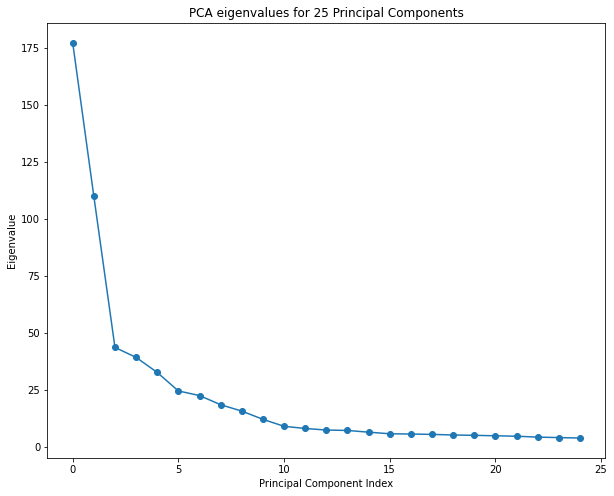

In [97]:
plt.figure(figsize=(10,8))
plt.scatter(range(25),eigenvalues)
plt.plot(range(25),eigenvalues)
plt.xlabel("Principal Component Index")
plt.ylabel("Eigenvalue")
plt.title("PCA eigenvalues for 25 Principal Components")
plt.show()

We can also plot the individual explained variances for each eigenvalue to try and find this optimal drop point but this is just a scaled by $\frac{1}{V}$ plot of the prior one and so gives the same answer of 2.

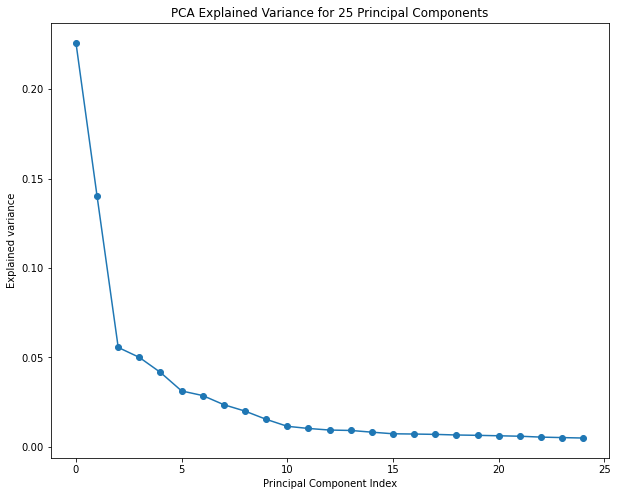

In [98]:
plt.figure(figsize=(10,8))
plt.scatter(range(25),explained_variances)
plt.plot(range(25),explained_variances)
plt.xlabel("Principal Component Index")
plt.ylabel("Explained variance")
plt.title("PCA Explained Variance for 25 Principal Components")
plt.show()

Now we have selected that the optimal dimensionality reduction is $m=2$ we will test if this passes a common test from research papers. In scientfic literature it is suggested that ideally the number of components chosen should cumulative explain around 80% of the total variance. We plot the cumulative variances for the first 25 components and identify the cumulative variance explained for the optimal dimensionality reduction chosen, $m=2$. We see that for $m=2$ we only explain in total 0.37 of the variance and the first 25 components altogether do not even explain 80% of the total variance. This is due to our data having a large number of inital components (784) with a large tail of plateaud (importantly not small enough) eigenvalues which when summed up in value far outweigh the first few eigenvalues summed together. So we may conclude that from looking at just the first 25 principle components we have an optimal dimensionality reduction of 2 but if we were to look at all the components this might not be the ideal case.

Cumulative variance explained for m=2:  0.3662003711220164


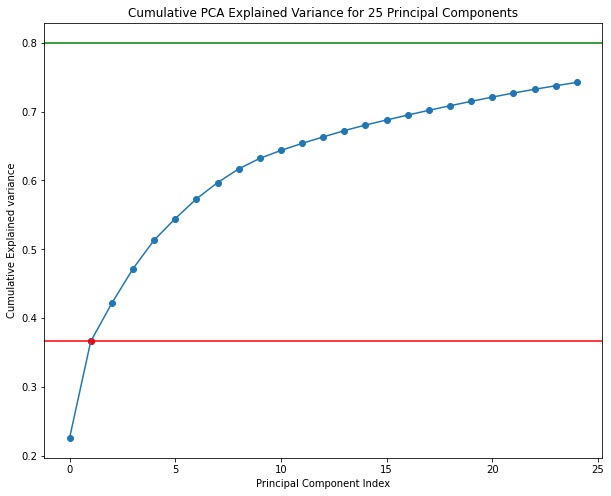

In [99]:
plt.figure(figsize=(10,8))
plt.scatter(range(25),np.cumsum(explained_variances))
plt.plot(range(25),np.cumsum(explained_variances))
plt.xlabel("Principal Component Index")
plt.ylabel("Cumulative Explained variance")
plt.title("Cumulative PCA Explained Variance for 25 Principal Components")
plt.scatter([1],np.cumsum(explained_variances[:2])[-1],c='r')
plt.axhline(np.cumsum(explained_variances[:2])[-1],c='r')
plt.axhline(0.8,c='g')
print("Cumulative variance explained for m=2: ",np.cumsum(explained_variances[:2])[-1])
plt.show()

2.1.3

We now consider the top 2 principle components which is what we identified to be the ideal dimensionality redution in the previous part. Since we are reducing our images from the space of 784 to 2 components we are able to plot this data in the plane.

In [100]:
# choose our number of principle components
k = 2
# compute the projection, the eigenvector and eigenvalues from our function
X_pca, eigenvectors, eigenvalues = pca_function(X,k)
X_pca.shape

(1000, 2)

In [104]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot"
]

We colour each point mapped to 2 dimensions according to it's class. We observe a fairly distinct clustering distribution. We have an apparent cluster strip which consists of a merging of groups 5 (Sandal), 7 (Sneaker) and 9 (Ankle boot) on the right side. This is actually a very reassuring clustering as we can see by the classes above that the dimensionality reduction still has retained the information of footwear vs non-footwear. We then see a few almost layer like strips beginning with 1 (Trouser) at the bottom followed by 3 (Dress) and then 0 (T-shirt/top). The other groups also have their own clusters but they are much more spread out and overlap a lot with other clusters. Overall, there is a lot of overlapping of clusters but considering we have reduced the dimension of each 28 by 28 pixel image to just 2 dimensions we have a very decent clustering partition that still retains key information about the images.

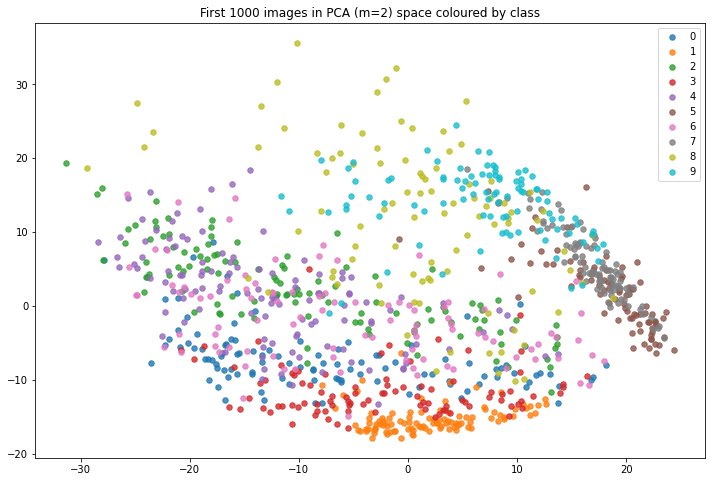

In [101]:
plt.figure(figsize=(12,8))
plt.title("First 1000 images in PCA (m=2) space coloured by class")
scatter_x = X_pca[:,0]
scatter_y = X_pca[:,1]
group = np.argmax(y_test[:1000]==1, axis=1)
for g in np.unique(group):
    i = np.where(group == g)
    plt.scatter(scatter_x[i], scatter_y[i], label=g, alpha=0.8, s=30)
plt.legend()
plt.show()

2.1.4

We can now apply another common unsupervised learning method to this reduced data, namely k-means clustering. This method works as follows: <br />
K is chosen as the number of clusters we wish to partition the data into. We begin with a first group of randomly selected centroids (average of cluster components), which are then used as the starting points for each clustering. It then performs iterative calculations based on minimisation of Euclidean metrics based 'within distances'. Iterations stop when either there is no change in their centroid values because the clustering has been successful or
the set number of iterations has been reached.

In [102]:
def k_means(X,k):

    n_samples, n_features = X.shape

    # number of clusters k
    

    # labels: assign every sample to a cluster at random
    np.random.seed(123)
    labels = np.random.randint(low=0, high=k, size=n_samples)
    X_labels = np.append(X, labels.reshape(-1,1), axis=1)

    # computing the centroids of each of the k clusters
    centroids = np.zeros((k, n_features))
    for i in range(k):
        centroids[i] = np.mean([x for x in X_labels if x[-1]==i], axis=0)[0:2]
    
    max_iter = 10000
    new_labels = np.zeros(len(X))
    difference = 0

    # k-means algorithm
    for i in range(max_iter):
        # distances: between data points and centroids
        distances = np.array([np.linalg.norm(X - c, axis=1) for c in centroids])
        # new_labels: computed by finding centroid with minimal distance
        new_labels = np.argmin(distances, axis=0)

        if (labels==new_labels).all():
            # labels unchanged
            labels = new_labels
            break
        else:
            # labels changed
            # difference: percentage of changed labels
            difference = np.mean(labels!=new_labels)
            labels = new_labels
            for c in range(k):
                # update centroids by taking the mean over associated data points
                if (labels == c).any():
                    centroids[c] = np.mean(X[labels==c], axis=0)
    
    return centroids, labels


We apply the k means clustering alogrithm to our reduced dimension data, varying the number of clusters between 2 and 10. We demostrate the clusterings as well each cluster's final centroid below for each k.

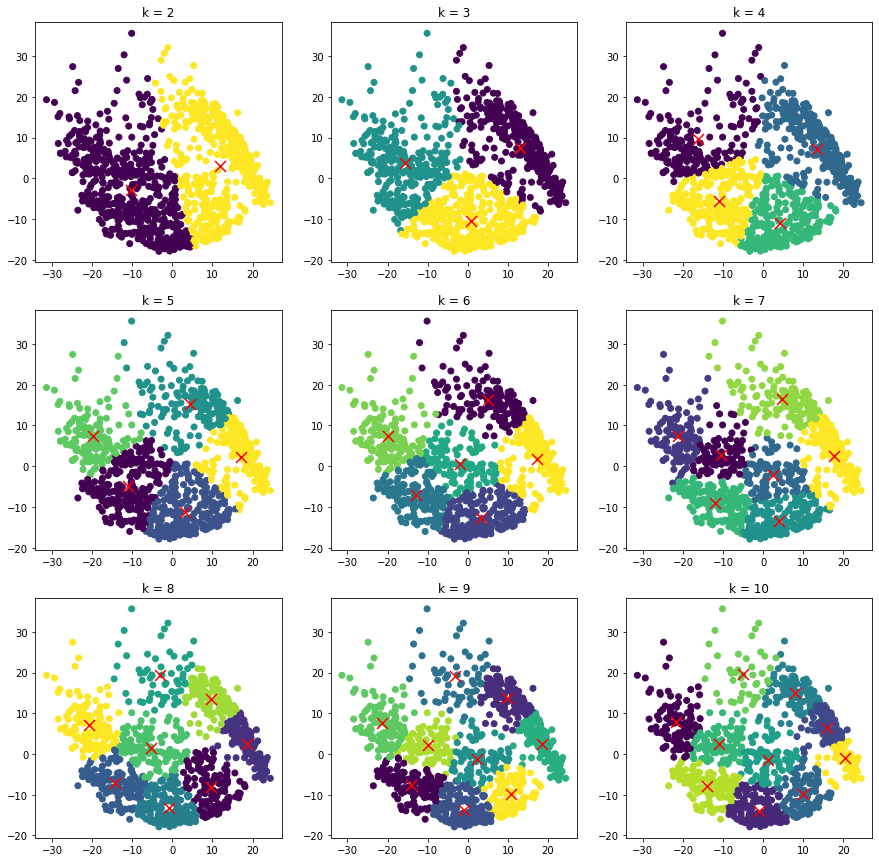

In [103]:
nrow = 3; ncol = 3

fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize = (15,15))

for i,ax in enumerate(axs.reshape(-1)): 
    
    centroids, labels = k_means(X_pca, i+2)
    
    ax.scatter(X_pca[:,0], X_pca[:,1], c=labels)
    ax.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', s=120)
    ax.set_title(f"k = {i+2}")
    

To find the optimal k we use a technique called the Elbow Method. We plot the the objective function values that were minimising in k means $$W=\sum_{l=1} \sum_{i \in c_l} || x^{(i)} - m_l||^2$$ for each k. We look for the 'elbow' in the curve which is when increasing k further brings no significant decrease in objective value. <br /> Using the Elbow Method we observe that the curve is fairly smooth and so it is difficult to choose an optimal k. This is why we decide to use another measure for the quality of clustering to gain some insight into the optimal number of clusters.

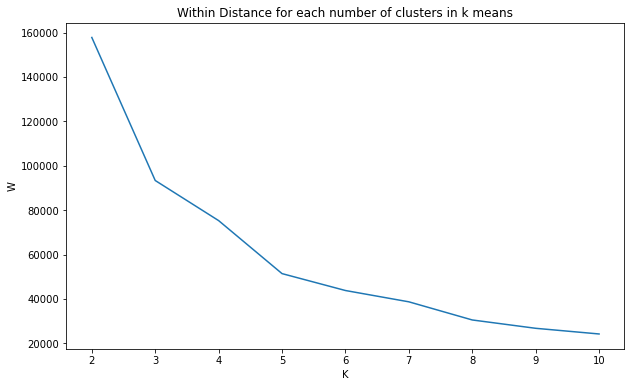

In [110]:
Ws = []
plt.figure(figsize=(10,6))
plt.title("Within Distance for each number of clusters in k means")
plt.ylabel("W")
plt.xlabel("K")
for k in range(2, 11):
    centroids, labels = k_means(X_pca, k)
    W = 0
    # calculate square of Euclidean distance of each point from its cluster center and add to current WSS
    for i in range(len(X_pca)):
        cent = centroids[labels[i]]
        W += (X_pca[i, 0] - cent[0]) ** 2 + (X_pca[i, 1] - cent[1]) ** 2
    Ws.append(W)
plt.plot(range(2,11),Ws)
plt.show()

The other quality of clustering measure we choose to apply is Silhoutte Scoring. To find the Silhoutte score we need two values. $a:=$ average distance between the observation and all other data points in the same cluster and $b:=$ the average distance between the observation and all other data points in the next nearest cluster.
The Silhouette score, S, is the mean of each individual observation silhoutte score

$$S = \frac{b - a}{max(a, b)} $$
The value of the final Silhouette score is between -1 and 1. If the score is towards 1 then the cluster is partitioned well from other clusters and densely populated. A value around 0 indicates overlapping clusters with observations close to the decision boundary of the nearest other clusters. A negative score represents that the observations may ne assigned to the incorrect clusters.

First we define a helper function which finds the pairwise euclidean distances between samples in the data. We will be able to use all these distances to find $b$ and $a$.

In [111]:

def pairwise_distances(points):
    '''
    Args:
        points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
    Returns:
        A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
    '''
    N, D = points.shape
    distance = np.empty((N, N))
    
    # distance matrix will be symmetric, so avoid redundant computations.
    for i in range(N):
        distance[i, i] = 0
        for j in range(i + 1, N):
            d = np.sqrt(np.power(points[i, :] - points[j, :], 2).sum())
            distance[i, j] = d
            distance[j, i] = d
            
    return distance

Importantly, for singleton clusters we define the Silhoutte Score to be 0.

In [112]:
def silhoutte(Xmat, d, labels):
    labels = np.asarray(labels)
    labels = labels[...,np.newaxis]
    X = np.concatenate((Xmat,labels),axis=1) #assign labels from clustering to each sample
    s = []
    for i in range(len(labels)): #loop over each sample
        x, xlab = X[i,:-1], X[i,-1] #separate sample and label
        dists1 = d[i][np.where(X[:,-1]==xlab)] #calculate mean intra cluster distances
        if len(dists1) == 1: #singleton cluster
            d1 = 0
        else:
            d1 = np.sum(dists1) / (len(dists1) - 1)
        mink = -1
        mindk = np.inf
        for k in labels: #finding nearest cluster for sample
            if k != xlab:
                dk = np.mean(d[i][np.where(X[:,-1]==k)])
                if dk < mindk:
                    mink = k 
                    mindk = dk

        dists2 = d[i][np.where(X[:,-1]!=mink)] #finding mean nearest cluster distances
        d2 = np.sum(dists2) / len(dists2)
        if len(dists1) == 1 or len(dists2) == 0: #for singleton clusters
            s.append(0)
        else:
            s.append((d2 - d1) / np.max((d1, d2)))
        
    return np.mean(s) #final score is mean across all sample scores

In [113]:
dk = pairwise_distances(X_pca) #find distances between all samples in the reduced dimension data

Using this goodness of clustering test we observe that for $k \in [2,10]$ the optimal k is 10 as it produces the highest silhoutte score meaning with 10 clusters we have the best overall partition and best density in each cluster.

2
3
4
5
6
7
8
9
10


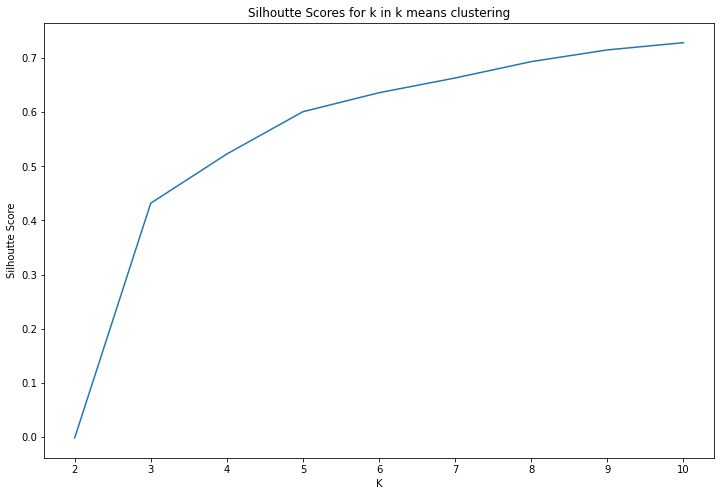

In [115]:
S_scores = []
for k in range(2, 11):
    print(k)
    _, labels = k_means(X_pca, k)
    s = silhoutte(X_pca, dk, labels)
    S_scores.append(s)
    
plt.figure(figsize=(12,8))
plt.ylabel("Silhoutte Score")
plt.xlabel("K")
plt.title("Silhoutte Scores for k in k means clustering")
plt.plot(range(2,11),S_scores)
plt.show()

Best k = 5

<a name="q22"></a>

## 2.2 Clustering of the feature matrix [^](#outline)

We now move on to new data relating to the social network of bottlenose dolphins. First we investigate the data regarding the features of the 62 dolphins.

In [116]:
F = np.load("./dolphins_F_62x32(1).npy")
A = np.load("./dolphins_A_62x62(1).npy")
names = pd.read_csv("./dolphin_names.csv")


2.2.1

First we standardise F as when we will be implementing average linkage for hierarchical clustering with euclidean metrics. The reason is again the same as for all other standardisations when using eucidean distances which is that the high scales of some features may unfairly dominate in euclidean distances leading to unfair clustering.

In [ ]:
F = standardise(F) #standardise F

In [ ]:
d = pairwise_distances(F) #find pairwise distances of the features

We now implement the criterion that we will use for merging in the hierarchical clustering algorithm which is average linkage function. It computes the distances between clusters as an average over all pairs of points. $$d_GA = \frac{1}{N_GN_H} \sum_{i\in G, j \in H} D_{ij}$$

In [ ]:
def average_linkage(distances, cluster_assignment, i, j):
    """
    This function computes the average linkage value between two clusters.
    Args:
      distances: A numpy array of pair-wise distances for the given points.
      cluster_assignment: A 1-D numpy array that assigns a cluster id for every point.
      i: the first cluster id.
      j: the second cluster id.
    Returns:
      The average distance between the two given clusters.
    """
    # Select the point indices of the first cluster.
    points_i = np.argwhere(cluster_assignment == i)
    # Select the point indices of the second cluster.
    points_j = np.argwhere(cluster_assignment == j)
    # Form a cartesian product between the indices in i and indices in j.
    pairs = np.array([[element_i.item(), element_j.item()]  for element_i in points_i for element_j in points_j])
    # Select the pair distances between the points in the two clusters from the distances matrix.
    pairs_distance = distances[pairs[:, 0], pairs[:, 1]]
    # Return the average
    return pairs_distance.mean()

We decide to implement an agglomerative scheme for hierarchical clustering (from the bottom up). So initially we have each sample as its own unique cluster before moving up levels. At each level we merge samples into clusters until we get the whole data set as one cluster. The criterion used for merging is what we previously defined: average linkage. We use the distances between all pairs of clusters to decide the next merger.

In [ ]:
def hierarchical_clustering(points, distances, linkage):
    """
    The hierarchical clustering algorithm start with every point as a single cluster and 
    each iteration merges two clusters into one. We may wish to store all the 
    intermediate clustering results with respect to the number of clusters left.

    Args:
     points: A numpy array of points having the shape (N, D), 
          where N is the number of points and D is the number of features.
     distances: A numpy array with shape (N, N) such that the element (i, j) is the computed
        distance between i-th point and j-th point in X.
     linkage: A linkage function from the above to call to compute the linkage values between two clusters.

    Returns:
     A numpy array of shape (N, N) of which each row stores the clustering assignment at each level.
     The first row, i.e. a[0, :], represents the highest level of clustering where all columns have the same index value.
     The second row, i.e. a[1, :], represents all the points assigned into two cluster indices.
     The last row, i.e. a[N - 1, :], represents the points assigned into N - 1 cluster indices.
    """ 
    N, D = points.shape
    assignments = np.zeros((N, N))
    
    # Begin with every point is its own cluster
    current_assignment = np.arange(N)
    
    # The id to be assigned for the next merged cluster
    next_cluster_id = N
    
    # Begin from level (N - 1) to level 1
    for level in range(N - 1, 0, -1):
        cluster_ids = np.unique(current_assignment)
        
        min_d = np.inf
        
        # Initialize the cluster ids to be merged in this iteration.
        cluster_a, cluster_b = (-1, -1) 
        
        # Now find the two clusters that have the minimum distance in between.
        for i in range(cluster_ids.size):
            for j in range(i + 1, cluster_ids.size):
                cluster_i = cluster_ids[i]
                cluster_j = cluster_ids[j]
                d = linkage(distances, current_assignment, cluster_i, cluster_j)    ## <-- EDIT THIS LINE
                if d < min_d:
                    min_d = d
                    cluster_a, cluster_b = (cluster_i, cluster_j)
                    
        
        # Merge the two clusters
        current_assignment[(current_assignment == cluster_a) | (current_assignment == cluster_b)] = next_cluster_id
        next_cluster_id += 1
        # Store the current cluster assignment into the assignments array.
        assignments[level, :] = current_assignment
        print(current_assignment) #return current clustering 
        
    return assignments

We can call the function defined above to report the clustering assignments from finest to coarsest.

In [ ]:
a = hierarchical_clustering(F, d, average_linkage)


[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 62 23
 24 25 26 27 28 29 30 62 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
[ 0  1  2  3 63  5  6  7  8  9 10 63 12 13 14 15 16 17 18 19 20 21 62 23
 24 25 26 27 28 29 30 62 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
[ 0  1  2  3 63  5  6  7  8 64 10 63 12 64 14 15 16 17 18 19 20 21 62 23
 24 25 26 27 28 29 30 62 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
[ 0  1  2  3 63 65 65  7  8 64 10 63 12 64 14 15 16 17 18 19 20 21 62 23
 24 25 26 27 28 29 30 62 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61]
[ 0  1  2  3 63 65 65  7  8 66 10 63 12 66 14 15 16 17 18 19 20 21 62 23
 24 25 26 27 28 29 30 62 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 66 58 59 60 61]
[ 0  1  2  3 63 65 65  7  8 66 10 63 12 66 14 15 1

2.2.2

We now will use the silhoutte score goodness of clustering measure on each level of clustering in the hierarchical clustering reported above. We have already defined the silhoutte score algorithm and we have already calculated the distance matrix for the samples.

We plot the scores to see which level maximises the silhoutte score. We observe that level 16 holds the optimal clustering.

Optimal Level: 16


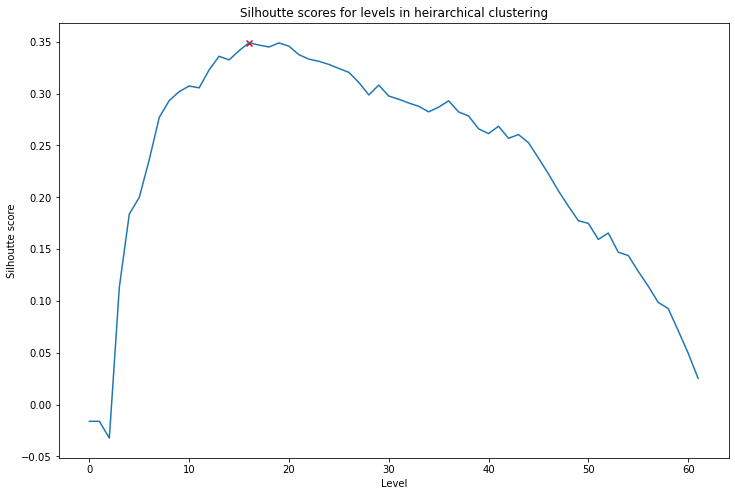

In [ ]:
scores = []
for i in range(a.shape[0]):
    s = silhoutte(F, d, a[i])
    scores.append(s)
opt = np.argmax(scores[:])
print("Optimal Level:", opt)
plt.figure(figsize=(12,8))
plt.ylabel("Silhoutte score")
plt.xlabel("Level")
plt.title("Silhoutte scores for levels in heirarchical clustering")
plt.plot(scores)
plt.scatter(opt,scores[opt], marker = "x", c = "r")
plt.show()

<a name="q23"></a>

## 2.3 Graph-based analysis  [^](#outline)

We now move on the analysis of the dolphin network via the graph structure encoded in the adjacency matrix. This matrix contains information on the edge connection of vertices of the dolphin samples based on frequent association.

2.3.1

First we would like to visualise the dolphin network.

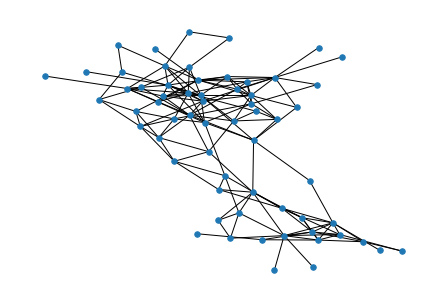

In [ ]:
# constructing a networkx graph object
g = nx.Graph(A)

# drawing networkx graph
nx.draw(g,node_size=30)

Next, we can begin to build up the necessary means to spectrally partition the dolphin network.

We start by defining the diagonal matrix of the node degrees.

In [ ]:
# define diagonal matrix of node degrees
weighted_degree = A.sum(axis=1) 

# create diagonal matrix of degree
D = np.diag(weighted_degree)

This means we are able to define the laplacian matrix which is useful in finding measures of distances and connectivity in graphs.

In [ ]:
# define Laplacian
L = D-A

We can now find the normalised laplacian $$L = I - D^{-\frac{1}{2}} A D^{-\frac{1}{2}}$$which is often better to use since it simplifies eigendecompositions due to it being symmetric. Further, with the normalised laplacian the interpretation of results can be viewed from a probabilistic side.

In [ ]:
# computing inverse square root vector of degree
weighted_degree_sqrt = 1.0 / np.sqrt(weighted_degree)

# set a diagonal matrix of the inverse square root of degree
D_inv_sqrt = np.diag(weighted_degree_sqrt)

# define the normalised Laplacian
L_norm = np.eye(A.shape[0]) - D_inv_sqrt.dot(A.dot(D_inv_sqrt))

We are now able to able to find the first two eigen values in terms of smallest magnitude. This will allow us to spectrally partition the graph in two.

In [ ]:
# return the smallest magnitude eigenvectors and eigenvalues
eigenvals, eigenvecs = linalg.eigsh(L_norm, 2, which="SM", return_eigenvectors=True)

In [ ]:
# printing the eigenvalues
print('The first eigenalue is: {}'.format(eigenvals[0]))
print('The second eigenalue is: {}'.format(eigenvals[1]))

The first eigenalue is: 1.6264303136703448e-16
The second eigenalue is: 0.03952455375743345


Using the second eigenvector as the decision criterion we can colour the graph. 

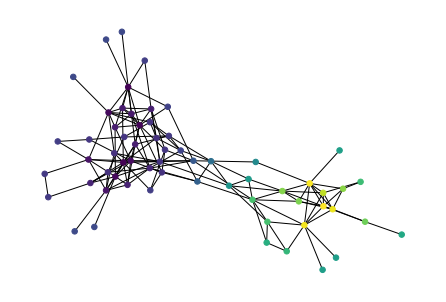

In [ ]:
# extract the second eigenvector
second_eigenvector = eigenvecs[:,1] 

# draw the network structure coloured by the second eigenvector
nx.draw(g, node_color=second_eigenvector, node_size=30)

We now map nodes with decision criterion values below 0 to one side of the cluster and those above 0 to the other side of the cluster.

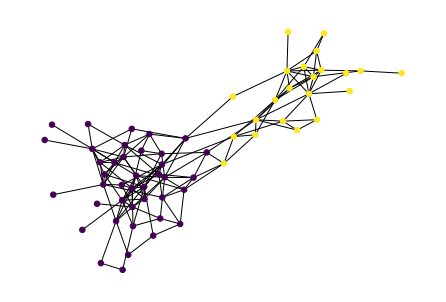

In [ ]:
# define a partition and binarize the negative and positive eigenvector values
spectral_partition = second_eigenvector
spectral_partition[spectral_partition<0] = 0 
spectral_partition[spectral_partition>0] = 1

# draw the spectral partition
nx.draw(g, node_color=spectral_partition, node_size=30)

2.3.2

We now define some other centrality measures that we will use to analyse the graph network and highlight the central dolphins in their community.

The degree centrality is simply the number of edges leading from each node.

In [134]:
def degree_centrality(X):
    d = np.sum(X, axis=1) # Degree: number of connections off node
    E = 0.5 * np.sum(d) # Edges: total number of connections
    return d / (2 * E)

Eigenvector centrality is derived from the eigendecomposition of the $A$. It gives higher scores to nodes which are connected to other highly central nodes.

In [135]:
def eigen_centrality(X):
    return abs(linalg.eigsh(X, 1)[1].reshape((-1,))) # Leading eigenvector of X ## Take absolute value in case negative

PageRank is the algorithm used in the Google search engine to determine the rank of webpages. It is defined for $\alpha \in [0,1]$ by $$c_{PR} = \alpha (AD^{-1})c_{PR} + (1-\alpha)\frac{1}{N}$$ 
This measure assigns higher centrality to nodes to connected nodes of importance. The teleportation parameter $\alpha$ makes sure a web searcher is not always sent to the most central node. Often the default value for this is 0.85.

In [136]:
def pageRank(X,alpha=0.85):
    D = np.diag(np.sum(X, axis=1)) # Diagonal matrix of node degrees
    M = X @ np.linalg.inv(D) # M = AD^-1
    A = np.eye(X.shape[0]) - alpha * M
    b = (1 - alpha) / X.shape[0] * np.ones(X.shape[0])
    return np.linalg.solve(A, b) # Solves for x in Ax = b

We return all the centrality values for each dolphin for each centrality measure.

In [137]:
# Prints values of three centrality measures for all nodes in the graph
centr0 = degree_centrality(A)
print("Degree Centrality:", centr0)
centr1 = eigen_centrality(A)
print("Eigenvector Centrality:", centr1)
centr2 = pageRank(A)
print("PageRank Centrality:", centr2)


Degree Centrality: [0.01886792 0.02515723 0.01257862 0.00943396 0.00314465 0.01257862
 0.01886792 0.01572327 0.01886792 0.02201258 0.01572327 0.00314465
 0.00314465 0.02515723 0.03773585 0.02201258 0.01886792 0.02830189
 0.02201258 0.01257862 0.02830189 0.01886792 0.00314465 0.00943396
 0.01886792 0.00943396 0.00943396 0.01572327 0.01572327 0.02830189
 0.01572327 0.00314465 0.00943396 0.03144654 0.01572327 0.00314465
 0.02201258 0.03459119 0.02515723 0.00628931 0.02515723 0.01572327
 0.01886792 0.02201258 0.01257862 0.03459119 0.00628931 0.01886792
 0.00314465 0.00628931 0.02201258 0.03144654 0.01257862 0.00628931
 0.02201258 0.00628931 0.00628931 0.02830189 0.00314465 0.01572327
 0.00314465 0.00943396]
Eigenvector Centrality: [0.12850353 0.04207615 0.03975712 0.07933476 0.02928739 0.00655926
 0.01219126 0.04290099 0.14310214 0.01219738 0.07525347 0.02928739
 0.03907614 0.01500469 0.31578285 0.16417581 0.20799426 0.01751244
 0.20249469 0.02067478 0.18447739 0.2073514  0.00243444 0.0873

We are able to show the highly central dolphins by ordering the dolphins by centrality for each measure and display their corresponding scores in a table.

In [138]:
high_cent0 = (-centr0).argsort()[:]
high_cent0_values = centr0[high_cent0]
high_cent1 = (-centr1).argsort()[:]
high_cent1_values = centr1[high_cent1]
high_cent2 = (-centr2).argsort()[:]
high_cent2_values = centr2[high_cent2]
print(high_cent0)
print(high_cent1)
print(high_cent2)
print(high_cent0_values)
print(high_cent1_values)
print(high_cent2_values)

[14 37 45 33 51 57 20 17 29  1 38 40 13 36 18 15  9 50 54 43 16 47 42  8
 21 24  6  0 41 59 34 30 28 27  7 10  2 52  5 44 19 32  3 61 26 23 25 56
 55 53 46 49 39 12 48  4 31 11 35 58 60 22]
[14 37 45 33 50 29 51 16 40 21 18 38 24 43 20 15  8 34 36 52  0 59 23 42
 47  3 44 10 28 55 61  7  1 30  2 12 53 46 35  4 11 58 49 54 39 19 17 57
 27 41 13  9  6 26  5 25 32 56 22 31 48 60]
[14 17 51 57 37 45 33 29 13  1 20 38  9 40 43 54 36  6 15 18 50 42 47 27
  8  0 21 24 16 41 34  7 30 10 28 59  5  2 32 19 44 52 25 26 61 23  3 49
 46 56 53 39 55 60 31 22 48  4 11 58 35 12]
[0.03773585 0.03459119 0.03459119 0.03144654 0.03144654 0.02830189
 0.02830189 0.02830189 0.02830189 0.02515723 0.02515723 0.02515723
 0.02515723 0.02201258 0.02201258 0.02201258 0.02201258 0.02201258
 0.02201258 0.02201258 0.01886792 0.01886792 0.01886792 0.01886792
 0.01886792 0.01886792 0.01886792 0.01886792 0.01572327 0.01572327
 0.01572327 0.01572327 0.01572327 0.01572327 0.01572327 0.01572327
 0.01257862 0.01257862 0.012

In [139]:
# Ordered dolphins for each centrality measure and their corresponding scores
topnames = pd.DataFrame()
topnames["Degree"] = names.iloc[high_cent0]["name"].to_numpy()
topnames["Degree Centrality"] = high_cent0_values
topnames["Eigenvector"] = names.iloc[high_cent1]["name"].to_numpy()
topnames["Eigenvector Centrality"] = high_cent1_values
topnames["PageRank"] = names.iloc[high_cent2]["name"].to_numpy()
topnames["PageRank Centrality"] = high_cent2_values
topnames

,Degree,Degree Centrality,Eigenvector,Eigenvector Centrality,PageRank,PageRank Centrality
0,Grin,0.037736,Grin,0.315783,Grin,0.032144
1,SN4,0.034591,SN4,0.300562,Jet,0.031728
2,Topless,0.034591,Topless,0.285005,Trigger,0.031299
3,Scabs,0.031447,Scabs,0.281099,Web,0.030095
4,Trigger,0.031447,TR99,0.217692,SN4,0.029875
...,...,...,...,...,...,...
57,Five,0.003145,Wave,0.002607,Cross,0.005080
58,SMN5,0.003145,MN23,0.002434,Five,0.005080
59,Whitetip,0.003145,Quasi,0.002434,Whitetip,0.004963
60,Zig,0.003145,TR82,0.002415,SMN5,0.004918


We notice that the most central node across all three measures is Grin. Further, we observe that the top 4 centrality nodes are the same for degree and eigenvector centrality measures whereas the the next top 3 from PageRank do not appear at all in either of the other measures top 4.

We can visualise the centrality of the nodes by creating a color map which shows green bars at nodes with high centrality, red bars at nodes with average centralities and blue bars at nodes with low centralities.

In [140]:
centralities = np.zeros((A.shape[0], 3))
centralities[:, 0] = centr0
centralities[:, 1] = centr1
centralities[:, 2] = centr2

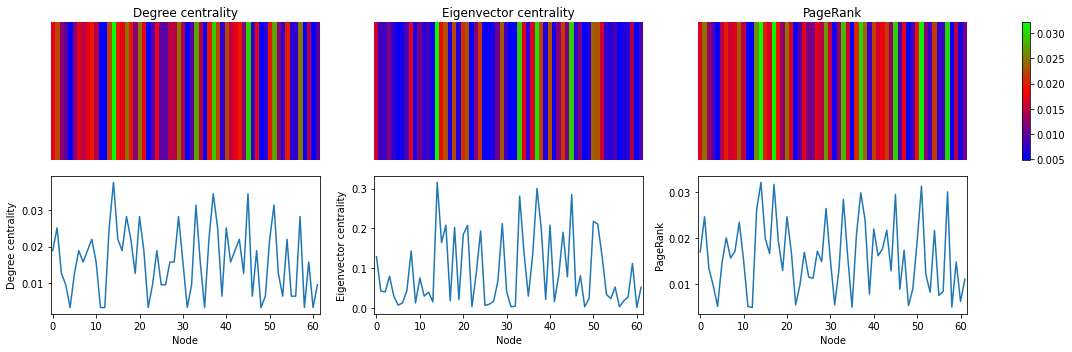

In [142]:
nrow = 2; ncol = 4
fig, axs = plt.subplots(nrows=nrow, ncols=ncol, figsize = (15,5), sharex = 'col',gridspec_kw = {'width_ratios':[1, 1, 1, 0.03]})
labs = ['Degree centrality', 'Eigenvector centrality', 'PageRank']
for i,ax in enumerate(axs.reshape(-1)): 
    if i < 3:
        im = ax.imshow(centralities[:,i][np.newaxis,:], aspect = 'auto', cmap = 'brg')
        ax.set_title(labs[i])
        ax.axis('off')
    if i == 3:
        plt.colorbar(im, ax)
    if i > 3 and i < 7:
        ax.plot(np.arange(0, 62), centralities[:,i-4])
        ax.set_xlabel('Node')
        ax.set_ylabel(labs[i-4])
    if i == 7:
        ax.axis("off")
plt.tight_layout()

In [143]:
# Pearson correlation between three centrality vectors
pearson = pd.DataFrame(centralities, columns = ['Degree', 'Eigenvector', 'PageRank']).corr(method='pearson')
print(pearson)

               Degree  Eigenvector  PageRank
Degree       1.000000     0.719648  0.983095
Eigenvector  0.719648     1.000000  0.609417
PageRank     0.983095     0.609417  1.000000


We notice that the patterns are similar in degree and pagerank centrality and quite different from eigenvector centrality. Specifically, in the distribution for the eigenvector centrality we see a distinct congregation of low centrality values at the edges of the graph (high and low node numbers). This difference is because these measures pick up on different distinct characteristics of an individual node's edge connections. Degree centrality does not take into consideration neighours local connectivity whereas eigenvector does consider global neighbour connectivity. This has some drawbacks especially for a node with a single connection to a hub node since this node will be deemed highly central. PageRank also takes into account neighbour connectivity but is damped by the teleportation parameter to reduced the effect outlined in eigenvector centrality. Since eigenvector centrality is more sensitive to nodes with a connection to hubs we see that eigenvalue centrality is less correlated with the other two.

We can also visualise the correlation in the rankings of the three measures using spearman correlation. We see that the most correlated ranking is degree and pagerank centrality, again due to the reason above. Further supporting the difference in sensitivity of eigenvector centrality to nodes connected to hubs, we see near no correlation between it's ranking and PageRank's. Interestingly, we do see some small correlation between degree and eigenvector centrality rankings which is surprising to see based on the reasoning above. The explanation for this is that we must not have any clear hub nodes in this network and so the sensitivity of eigenvector centrality to nodes connected to hubs is not captured.

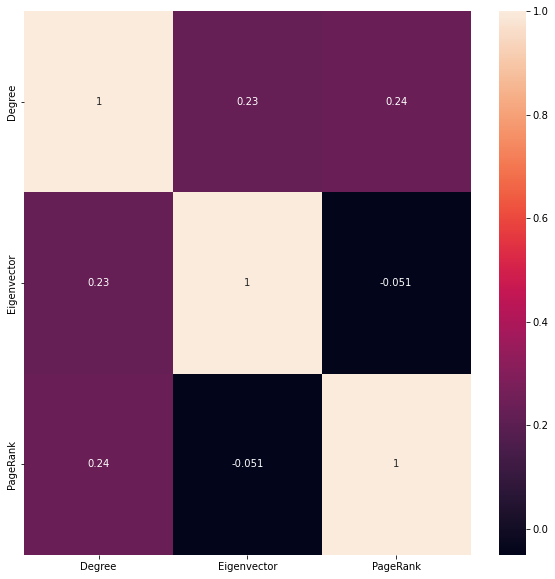

In [125]:
# Spearman correlation between three rankings from the three centralities
rankings = np.zeros((A.shape[0], 3))
rankings[:, 0] = high_cent0
rankings[:, 1] = high_cent1
rankings[:, 2] = high_cent2
spearman = pd.DataFrame(rankings, columns = ['Degree', 'Eigenvector', 'PageRank']).corr(method='spearman')
plt.figure(figsize=(10,10))
sns.heatmap(spearman, annot = True)
plt.show()

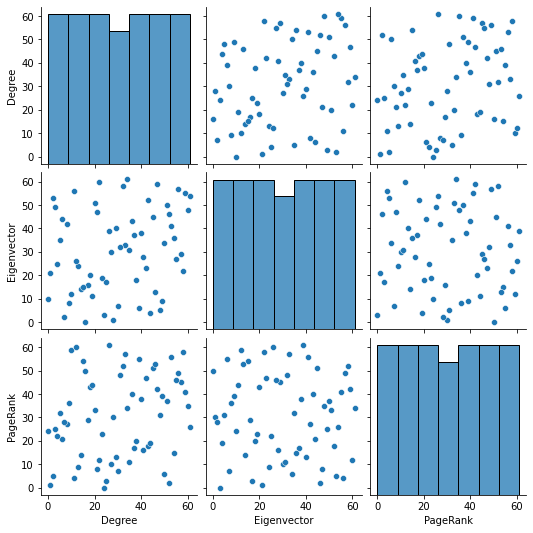

In [128]:
sns.pairplot(pd.DataFrame(rankings, columns = ['Degree', 'Eigenvector', 'PageRank']))
plt.show()

Finally, we are able to compare the most central dolphins from our investigation to those in the scientists report. We see that we agree on Grin being the most central dolphin to community, followed up closely by SN4 and Topless since these rankings came from those measures. So we can conclude that degree or eigenvector centrality would be most appropriate to use to study this community. However, interestingly the scientists spotted that there were three main groups in their community but we did not really explore this since we used spectral partitioning to find a bipartition. 

<a name="task-3"></a>

# Task 3: Mastery Component [^](#outline)

<a name="q31"></a>

## 3.1 Non-Negative Matrix Factorization (NMF) for dimensionality reduction  [^](#outline)

<a name="q32"></a>

## 3.2 Community detection [^](#outline)